<a href="https://colab.research.google.com/github/syedanida/Computer-Vision/blob/main/Part_2_Transfer_Learning_on_Various_Modalities.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 1. Image Transfer Learning

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import time
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

In [ ]:
# Set random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
# Hyperparameters
IMG_SIZE = 224  # Standard input size for MobileNetV2
BATCH_SIZE = 32
EPOCHS = 20
LEARNING_RATE = 0.001
FINE_TUNING_LEARNING_RATE = 0.0001  # Lower learning rate for fine-tuning

In [ ]:
def download_dataset():
    """Download and extract the CIFAR-10 dataset"""
    print("Downloading CIFAR-10 dataset...")

    # Load the CIFAR-10 dataset
    (train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.cifar10.load_data()

    # Normalize pixel values to be between 0 and 1
    train_images, test_images = train_images / 255.0, test_images / 255.0

    # Define class names for CIFAR-10
    class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
                   'dog', 'frog', 'horse', 'ship', 'truck']

    # Create directories for the data
    base_dir = os.path.join(os.getcwd(), 'cifar10_dataset')
    train_dir = os.path.join(base_dir, 'train')
    validation_dir = os.path.join(base_dir, 'validation')

    # Create all class directories
    for class_name in class_names:
        os.makedirs(os.path.join(train_dir, class_name), exist_ok=True)
        os.makedirs(os.path.join(validation_dir, class_name), exist_ok=True)

    # Print dataset statistics
    print(f"Training images: {len(train_images)}, shape: {train_images[0].shape}")
    print(f"Test images: {len(test_images)}, shape: {test_images[0].shape}")

    # Split the training set to create a validation set (20% of the training data)
    validation_split = 0.2
    val_size = int(len(train_images) * validation_split)

    # Shuffle the training data
    indices = np.arange(len(train_images))
    np.random.shuffle(indices)
    train_indices = indices[val_size:]
    val_indices = indices[:val_size]

    # Save images to disk
    def save_images_to_dirs(images, labels, indices, base_dir, subset_name):
        counts = {class_name: 0 for class_name in class_names}

        print(f"Saving {subset_name} images...")
        for i, idx in enumerate(indices):
            img = images[idx]
            label = labels[idx][0]  # Labels are in format [[label]]
            class_name = class_names[label]

            # Create save path
            save_dir = os.path.join(base_dir, subset_name, class_name)
            save_path = os.path.join(save_dir, f"{class_name}_{counts[class_name]}.png")

            # Save the image
            plt.imsave(save_path, img)
            counts[class_name] += 1

            # Print progress
            if (i + 1) % 1000 == 0:
                print(f"  Saved {i + 1}/{len(indices)} {subset_name} images")

        # Print statistics
        for class_name in class_names:
            print(f"  {subset_name} {class_name} images: {counts[class_name]}")

        return counts

    # Save training images
    train_counts = save_images_to_dirs(
        train_images, train_labels, train_indices, base_dir, 'train')

    # Save validation images
    val_counts = save_images_to_dirs(
        train_images, train_labels, val_indices, base_dir, 'validation')

    # Save test images (you might want to use these later)
    test_dir = os.path.join(base_dir, 'test')
    for class_name in class_names:
        os.makedirs(os.path.join(test_dir, class_name), exist_ok=True)

    test_counts = save_images_to_dirs(
        test_images, test_labels, np.arange(len(test_images)), base_dir, 'test')

    # Print total counts
    print("\nDataset statistics:")
    print(f"Total training images: {sum(train_counts.values())}")
    print(f"Total validation images: {sum(val_counts.values())}")
    print(f"Total test images: {sum(test_counts.values())}")

    return train_dir, validation_dir

In [ ]:
# Create data generators with augmentation
def create_data_generators(train_dir, validation_dir):
    """Create data generators with appropriate augmentation"""

    # Data augmentation for training
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    # Only rescaling for validation
    validation_datagen = ImageDataGenerator(rescale=1./255)

    # Create generators
    train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='binary'
    )

    validation_generator = validation_datagen.flow_from_directory(
        validation_dir,
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='binary'
    )

    return train_generator, validation_generator


In [ ]:
# Build feature extraction model (freezing base model)
def build_feature_extraction_model():
    """Build a model using MobileNetV2 as a feature extractor (frozen)"""

    # Load pre-trained MobileNetV2 model
    base_model = MobileNetV2(
        input_shape=(IMG_SIZE, IMG_SIZE, 3),
        include_top=False,
        weights='imagenet'
    )

    # Freeze the base model
    base_model.trainable = False

    # Add custom classification head
    inputs = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    x = base_model(inputs, training=False)  # Pass training=False to ensure BatchNorm runs in inference mode
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.2)(x)  # Add dropout for regularization
    outputs = Dense(1, activation='sigmoid')(x)

    # Combine inputs and outputs into model
    model = Model(inputs, outputs)

    # Compile model
    model.compile(
        optimizer=Adam(learning_rate=LEARNING_RATE),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model, base_model

In [ ]:
# Build fine-tuning model (unfreezing top layers of base model)
def build_fine_tuning_model(base_model):
    """Build a model using MobileNetV2 with fine-tuning of top layers"""

    # Unfreeze top layers
    base_model.trainable = True

    # Freeze all layers except the top few
    fine_tune_at = -20  # Number of layers to fine-tune (from the end)
    for layer in base_model.layers[:fine_tune_at]:
        layer.trainable = False

    # Check how many layers are trainable
    trainable_count = sum(layer.trainable for layer in base_model.layers)
    total_count = len(base_model.layers)
    print(f"Trainable layers: {trainable_count}/{total_count}")

    # Add custom classification head
    inputs = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    x = base_model(inputs)
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.2)(x)  # Add dropout for regularization
    outputs = Dense(1, activation='sigmoid')(x)

    # Combine inputs and outputs into model
    model = Model(inputs, outputs)

    # Compile model with lower learning rate
    model.compile(
        optimizer=Adam(learning_rate=FINE_TUNING_LEARNING_RATE),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model

In [ ]:
# Train and evaluate the model
def train_and_evaluate(model, train_generator, validation_generator, model_name):
    """Train and evaluate the model, returning history and metrics"""

    # Set up callbacks
    callbacks = [
        EarlyStopping(
            monitor='val_loss',
            patience=5,
            restore_best_weights=True
        ),
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=3,
            min_lr=1e-6
        )
    ]

    # Train the model
    print(f"\nTraining {model_name} model...")
    start_time = time.time()

    history = model.fit(
        train_generator,
        steps_per_epoch=train_generator.samples // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=validation_generator,
        validation_steps=validation_generator.samples // BATCH_SIZE,
        callbacks=callbacks
    )

    training_time = time.time() - start_time
    print(f"Training time: {training_time:.2f} seconds")

    # Evaluate the model
    print(f"\nEvaluating {model_name} model...")
    evaluation = model.evaluate(validation_generator)

    print(f"{model_name} - Validation Loss: {evaluation[0]:.4f}")
    print(f"{model_name} - Validation Accuracy: {evaluation[1]:.4f}")

    return history, evaluation, training_time

In [ ]:
# Plot training history
def plot_training_history(history, model_name):
    """Plot training and validation accuracy and loss"""

    plt.figure(figsize=(12, 5))

    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training')
    plt.plot(history.history['val_accuracy'], label='Validation')
    plt.title(f'{model_name} - Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(alpha=0.3)

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training')
    plt.plot(history.history['val_loss'], label='Validation')
    plt.title(f'{model_name} - Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(alpha=0.3)

    plt.tight_layout()
    plt.savefig(f"{model_name.replace(' ', '_')}_history.png", dpi=300, bbox_inches='tight')
    plt.show()

In [ ]:
# Visualize model predictions
def visualize_predictions(model, validation_generator, model_name, num_samples=10):
    """Visualize predictions on sample images"""

    # Get a batch of validation data
    validation_generator.reset()
    batch_images, batch_labels = next(validation_generator)

    # Make predictions
    predictions = model.predict(batch_images[:num_samples])
    predicted_classes = (predictions > 0.5).astype(int).flatten()

    # Plot images with predictions
    plt.figure(figsize=(15, 10))

    for i in range(num_samples):
        plt.subplot(2, 5, i + 1)

        # Display the image
        plt.imshow(batch_images[i])

        # Get prediction and true label
        true_label = "dog" if batch_labels[i] == 1 else "cat"
        pred_label = "dog" if predicted_classes[i] == 1 else "cat"
        confidence = predictions[i][0] if predicted_classes[i] == 1 else 1 - predictions[i][0]

        # Set title color based on correctness
        color = "green" if true_label == pred_label else "red"

        plt.title(
            f"True: {true_label}\nPred: {pred_label} ({confidence:.2f})",
            color=color
        )
        plt.axis('off')

    plt.suptitle(f"{model_name} - Sample Predictions", fontsize=16)
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.savefig(f"{model_name.replace(' ', '_')}_predictions.png", dpi=300, bbox_inches='tight')
    plt.show()

In [ ]:
# Compare results
def compare_results(feature_extraction_metrics, fine_tuning_metrics,
                   feature_extraction_time, fine_tuning_time):
    """Compare metrics and training times between approaches"""

    labels = ["Feature Extraction", "Fine-Tuning"]
    accuracies = [feature_extraction_metrics[1], fine_tuning_metrics[1]]
    times = [feature_extraction_time, fine_tuning_time]

    # Plot accuracy comparison
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    bars = plt.bar(labels, accuracies, color=["#3498db", "#e74c3c"])
    plt.title("Validation Accuracy Comparison")
    plt.ylabel("Accuracy")
    plt.ylim(0.7, 1.0)  # Adjust based on actual values

    # Add values on top of bars
    for bar, acc in zip(bars, accuracies):
        plt.text(
            bar.get_x() + bar.get_width() / 2,
            bar.get_height() + 0.01,
            f"{acc:.4f}",
            ha="center",
            fontweight="bold"
        )

    # Plot training time comparison
    plt.subplot(1, 2, 2)
    bars = plt.bar(labels, times, color=["#3498db", "#e74c3c"])
    plt.title("Training Time Comparison")
    plt.ylabel("Time (seconds)")

    # Add values on top of bars
    for bar, time_val in zip(bars, times):
        plt.text(
            bar.get_x() + bar.get_width() / 2,
            bar.get_height() + 20,
            f"{time_val:.0f}s",
            ha="center",
            fontweight="bold"
        )

    plt.tight_layout()
    plt.savefig("image_transfer_learning_comparison.png", dpi=300, bbox_inches="tight")
    plt.show()

In [ ]:
def main():
    # Download dataset
    print("Step 1: Downloading and exploring the dataset...")
    train_dir, validation_dir = download_dataset()

    # Create data generators
    print("\nStep 2: Creating data generators...")
    train_generator, validation_generator = create_data_generators(train_dir, validation_dir)

    # Feature Extraction Approach
    print("\nStep 3a: Building and training feature extraction model...")
    feature_extraction_model, base_model = build_feature_extraction_model()
    feature_extraction_history, feature_extraction_metrics, feature_extraction_time = train_and_evaluate(
        feature_extraction_model, train_generator, validation_generator, "Feature Extraction"
    )

    # Plot Feature Extraction results
    plot_training_history(feature_extraction_history, "Feature Extraction")
    visualize_predictions(feature_extraction_model, validation_generator, "Feature Extraction")

    # Fine-Tuning Approach
    print("\nStep 3b: Building and training fine-tuning model...")
    fine_tuning_model = build_fine_tuning_model(base_model)
    fine_tuning_history, fine_tuning_metrics, fine_tuning_time = train_and_evaluate(
        fine_tuning_model, train_generator, validation_generator, "Fine-Tuning"
    )

    # Plot Fine-Tuning results
    plot_training_history(fine_tuning_history, "Fine-Tuning")
    visualize_predictions(fine_tuning_model, validation_generator, "Fine-Tuning")

    # Compare approaches
    print("\nStep 4: Comparing feature extraction and fine-tuning approaches...")
    compare_results(
        feature_extraction_metrics, fine_tuning_metrics,
        feature_extraction_time, fine_tuning_time
    )

In [ ]:
if __name__ == "__main__":
    train_dir, validation_dir = download_dataset()
    print(f"\nTraining directory: {train_dir}")
    print(f"Validation directory: {validation_dir}")

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
Training images: 50000, shape: (32, 32, 3)
Test images: 10000, shape: (32, 32, 3)
Saving train images...
  Saved 1000/40000 train images
  Saved 2000/40000 train images
  Saved 3000/40000 train images
  Saved 4000/40000 train images
  Saved 5000/40000 train images
  Saved 6000/40000 train images
  Saved 7000/40000 train images
  Saved 8000/40000 train images
  Saved 9000/40000 train images
  Saved 10000/40000 train images
  Saved 11000/40000 train images
  Saved 12000/40000 train images
  Saved 13000/40000 train images
  Saved 14000/40000 train images
  Saved 15000/40000 train images
  Saved 16000/40000 train images
  Saved 17000/40000 train images
  Saved 18000/40000 train images
  Saved 19000/40000 train images
  Saved 20000/40000 train images
  Saved 21000/40000 train images
  Saved 22000/40000 train images
  Saved 23000/40000 train images
  Saved 24000/40000 train images
  Saved 25000/40000 train images
  Saved 26000/40000 train 

### 2. Audio Transfer learning

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow_hub as hub
import time
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
class AudioTransferLearning:
    def __init__(self, n_classes=10, yamnet_embedding_dim=1024):
        """
        Initialize the Audio Transfer Learning class

        Parameters:
        -----------
        n_classes : int
            Number of audio classes
        yamnet_embedding_dim : int
            Dimension of YAMNet embeddings (1024 by default)
        """
        self.n_classes = n_classes

        # Load YAMNet model from TensorFlow Hub
        print("Loading YAMNet model from TensorFlow Hub...")
        try:
            self.yamnet_model = hub.load('https://tfhub.dev/google/yamnet/1')
            print("YAMNet model loaded successfully!")
            self.yamnet_embedding_dim = yamnet_embedding_dim
        except Exception as e:
            print(f"Error loading YAMNet model: {e}")
            print("Using simulated embeddings instead...")
            self.yamnet_model = None
            self.yamnet_embedding_dim = yamnet_embedding_dim

        # Initialize variables
        self.X_train = None
        self.X_test = None
        self.y_train = None
        self.y_test = None
        self.model = None
        self.history = None
        self.class_names = None

    def generate_synthetic_data(self, n_samples=500, test_size=0.2):
        """
        Generate synthetic data to simulate YAMNet embeddings

        Parameters:
        -----------
        n_samples : int
            Number of synthetic samples to generate
        test_size : float
            Proportion of data to use for testing

        Returns:
        --------
        X_train, X_test, y_train, y_test : numpy arrays
            Training and test data
        """
        print("Generating synthetic audio embeddings...")

        # Generate synthetic class names
        self.class_names = [f"Class_{i}" for i in range(self.n_classes)]

        # Generate synthetic embeddings (simulating YAMNet feature vectors)
        features = np.random.randn(n_samples, self.yamnet_embedding_dim) * 0.1

        # Generate synthetic labels
        labels = np.random.randint(0, self.n_classes, size=n_samples)

        # Add class-specific patterns to make the task learnable
        for i in range(n_samples):
            class_idx = labels[i]

            # Add a class-specific pattern to each embedding
            # This simulates class-specific audio features
            pattern_start = (class_idx * 100) % self.yamnet_embedding_dim
            pattern_end = min(pattern_start + 50, self.yamnet_embedding_dim)

            # Enhance features for this class
            features[i, pattern_start:pattern_end] += 0.5

        # One-hot encode labels
        labels_onehot = keras.utils.to_categorical(labels, num_classes=self.n_classes)

        # Split into training and test sets
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            features, labels_onehot, test_size=test_size, random_state=42, stratify=labels
        )

        print(f"Synthetic data generated: {self.X_train.shape[0]} training samples, {self.X_test.shape[0]} test samples")
        print(f"Feature vector dimension: {self.X_train.shape[1]}")
        return self.X_train, self.X_test, self.y_train, self.y_test

    def build_model(self, dropout_rate=0.3, model_type='feature_extraction'):
        """
        Build a model for transfer learning on top of YAMNet embeddings

        Parameters:
        -----------
        dropout_rate : float
            Dropout rate for regularization
        model_type : str
            Type of transfer learning: 'feature_extraction' or 'fine_tuning'

        Returns:
        --------
        model : keras.Model
            The compiled model
        """
        if model_type not in ['feature_extraction', 'fine_tuning']:
            raise ValueError("model_type must be either 'feature_extraction' or 'fine_tuning'")

        # Get input shape from training data
        input_shape = self.X_train.shape[1]

        if model_type == 'feature_extraction':
            # Feature extraction approach - we only train a new classifier on top of YAMNet embeddings
            inputs = keras.Input(shape=(input_shape,))
            x = layers.Dense(256, activation='relu')(inputs)
            x = layers.BatchNormalization()(x)
            x = layers.Dropout(dropout_rate)(x)
            x = layers.Dense(128, activation='relu')(x)
            x = layers.BatchNormalization()(x)
            x = layers.Dropout(dropout_rate * 0.7)(x)
            outputs = layers.Dense(self.n_classes, activation='softmax')(x)

            self.model = keras.Model(inputs=inputs, outputs=outputs)

            # Compile the model
            self.model.compile(
                optimizer=keras.optimizers.Adam(learning_rate=0.001),
                loss='categorical_crossentropy',
                metrics=['accuracy']
            )

        else:  # fine_tuning
            # For demonstration, we'll simulate fine-tuning with a deeper network
            # and lower learning rate, but still using the extracted features

            inputs = keras.Input(shape=(input_shape,))
            x = layers.Dense(512, activation='relu')(inputs)
            x = layers.BatchNormalization()(x)
            x = layers.Dropout(dropout_rate)(x)
            x = layers.Dense(256, activation='relu')(x)
            x = layers.BatchNormalization()(x)
            x = layers.Dropout(dropout_rate * 0.8)(x)
            x = layers.Dense(128, activation='relu')(x)
            x = layers.BatchNormalization()(x)
            x = layers.Dropout(dropout_rate * 0.6)(x)
            outputs = layers.Dense(self.n_classes, activation='softmax')(x)

            self.model = keras.Model(inputs=inputs, outputs=outputs)

            # Compile with lower learning rate for fine-tuning
            self.model.compile(
                optimizer=keras.optimizers.Adam(learning_rate=0.0001),  # Lower learning rate
                loss='categorical_crossentropy',
                metrics=['accuracy']
            )

        # Print model summary
        self.model.summary()

        print(f"Built model for {model_type} approach")
        return self.model

    def train(self, epochs=20, batch_size=32):
        """
        Train the model

        Parameters:
        -----------
        epochs : int
            Number of training epochs
        batch_size : int
            Batch size for training

        Returns:
        --------
        history : History object
            Training history
        """
        if self.model is None:
            self.build_model()

        # Add early stopping and learning rate reduction
        callbacks = [
            keras.callbacks.EarlyStopping(
                monitor='val_loss', patience=5, restore_best_weights=True, verbose=1
            ),
            keras.callbacks.ReduceLROnPlateau(
                monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1
            )
        ]

        # Train the model
        print("\nTraining audio classification model...")
        self.history = self.model.fit(
            self.X_train, self.y_train,
            epochs=epochs,
            batch_size=batch_size,
            validation_split=0.2,
            callbacks=callbacks,
            verbose=1
        )

        return self.history

    def evaluate(self):
        """
        Evaluate the model on test data

        Returns:
        --------
        test_acc : float
            Test accuracy
        cm : numpy array
            Confusion matrix
        y_pred_classes : numpy array
            Predicted classes
        y_true_classes : numpy array
            True classes
        """
        # Evaluate the model
        test_loss, test_acc = self.model.evaluate(self.X_test, self.y_test, verbose=1)
        print(f"Test accuracy: {test_acc:.4f}")

        # Get predictions
        y_pred = self.model.predict(self.X_test)
        y_pred_classes = np.argmax(y_pred, axis=1)
        y_true_classes = np.argmax(self.y_test, axis=1)

        # Compute confusion matrix
        cm = confusion_matrix(y_true_classes, y_pred_classes)

        # Print classification report
        if self.class_names:
            print("\nClassification Report:")
            print(classification_report(y_true_classes, y_pred_classes,
                                       target_names=self.class_names))
        else:
            print("\nClassification Report:")
            print(classification_report(y_true_classes, y_pred_classes))

        return test_acc, cm, y_pred_classes, y_true_classes

    def visualize_training_history(self):
        """
        Visualize the training history
        """
        if self.history is None:
            print("Model has not been trained yet.")
            return

        # Plotting training history
        plt.figure(figsize=(12, 5))

        # Plot accuracy
        plt.subplot(1, 2, 1)
        plt.plot(self.history.history['accuracy'], label='Train Accuracy')
        plt.plot(self.history.history['val_accuracy'], label='Validation Accuracy')
        plt.title('Model Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend(loc='lower right')
        plt.grid(True, alpha=0.3)

        # Plot loss
        plt.subplot(1, 2, 2)
        plt.plot(self.history.history['loss'], label='Train Loss')
        plt.plot(self.history.history['val_loss'], label='Validation Loss')
        plt.title('Model Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend(loc='upper right')
        plt.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

    def visualize_confusion_matrix(self):
        """
        Visualize the confusion matrix
        """
        # Evaluate on test data
        _, cm, _, _ = self.evaluate()

        # Plot confusion matrix
        plt.figure(figsize=(10, 8))

        # Use class names if available
        if self.class_names and len(self.class_names) <= 10:  # Only use labels if not too many classes
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                       xticklabels=self.class_names, yticklabels=self.class_names)
        else:
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')

        plt.title('Confusion Matrix - Audio Classification')
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.tight_layout()
        plt.show()

    def save_model(self, model_path='audio_yamnet_model'):
        """
        Save the trained model

        Parameters:
        -----------
        model_path : str
            Path to save the model
        """
        if self.model is None:
            print("No model to save. Train a model first.")
            return

        # Create directory if it doesn't exist
        os.makedirs(model_path, exist_ok=True)

        # Save the model
        self.model.save(model_path)

        # Save class names
        if self.class_names:
            with open(f'{model_path}/class_names.txt', 'w') as f:
                for name in self.class_names:
                    f.write(f"{name}\n")

        print(f"Model saved to {model_path}")

    def load_model(self, model_path='audio_yamnet_model'):
        """
        Load a trained model

        Parameters:
        -----------
        model_path : str
            Path to the saved model

        Returns:
        --------
        model : keras.Model
            The loaded model
        """
        # Load the model
        self.model = keras.models.load_model(model_path)

        # Load class names if available
        class_names_path = f'{model_path}/class_names.txt'
        if os.path.exists(class_names_path):
            with open(class_names_path, 'r') as f:
                self.class_names = [line.strip() for line in f.readlines()]

        print(f"Model loaded from {model_path}")
        print(f"Class names: {self.class_names}")

        return self.model

In [ ]:
# Run demonstration for both approaches
def run_audio_transfer_learning_demo():
    # Initialize the Audio Transfer Learning class
    n_classes = 5
    audio_tl = AudioTransferLearning(n_classes=n_classes)

    # Generate synthetic data (since we don't have real audio files)
    X_train, X_test, y_train, y_test = audio_tl.generate_synthetic_data(n_samples=1000, test_size=0.2)

    # Compare both transfer learning approaches
    histories = {}

    # 1. Feature Extraction Approach
    print("\n=== Feature Extraction Approach ===")
    model_fe = audio_tl.build_model(dropout_rate=0.3, model_type='feature_extraction')
    history_fe = audio_tl.train(epochs=15, batch_size=32)
    fe_acc, _, _, _ = audio_tl.evaluate()
    audio_tl.visualize_training_history()
    audio_tl.visualize_confusion_matrix()

    # Store history for comparison
    histories['feature_extraction'] = history_fe
    fe_val_acc = max(history_fe.history['val_accuracy'])

    # 2. Fine-Tuning Approach (simplified)
    print("\n=== Fine-Tuning Approach ===")
    model_ft = audio_tl.build_model(dropout_rate=0.3, model_type='fine_tuning')
    history_ft = audio_tl.train(epochs=20, batch_size=32)  # More epochs for fine-tuning
    ft_acc, _, _, _ = audio_tl.evaluate()
    audio_tl.visualize_training_history()
    audio_tl.visualize_confusion_matrix()

    # Store history for comparison
    histories['fine_tuning'] = history_ft
    ft_val_acc = max(history_ft.history['val_accuracy'])

    # Compare the two approaches
    plt.figure(figsize=(12, 5))

    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(histories['feature_extraction'].history['val_accuracy'], label='Feature Extraction')
    plt.plot(histories['fine_tuning'].history['val_accuracy'], label='Fine-Tuning')
    plt.title('Validation Accuracy Comparison')
    plt.xlabel('Epoch')
    plt.ylabel('Validation Accuracy')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(histories['feature_extraction'].history['val_loss'], label='Feature Extraction')
    plt.plot(histories['fine_tuning'].history['val_loss'], label='Fine-Tuning')
    plt.title('Validation Loss Comparison')
    plt.xlabel('Epoch')
    plt.ylabel('Validation Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Print comparison summary
    print("\n=== Transfer Learning Approaches Comparison ===")
    print(f"Feature Extraction - Best Validation Accuracy: {fe_val_acc:.4f}, Test Accuracy: {fe_acc:.4f}")
    print(f"Fine-Tuning - Best Validation Accuracy: {ft_val_acc:.4f}, Test Accuracy: {ft_acc:.4f}")
    print(f"Improvement with Fine-Tuning: {(ft_acc - fe_acc) * 100:.2f}%")

    return audio_tl, histories

Loading YAMNet model from TensorFlow Hub...
YAMNet model loaded successfully!
Generating synthetic audio embeddings...
Synthetic data generated: 800 training samples, 200 test samples
Feature vector dimension: 1024

=== Feature Extraction Approach ===


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       262,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 297,477 (1.13 MB)

 Trainable params: 296,709 (1.13 MB)

 Non-trainable params: 768 (3.00 KB)

Built model for feature_extraction approach

Training audio classification model...
Epoch 1/15
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.7744 - loss: 0.7525 - val_accuracy: 1.0000 - val_loss: 0.5863 - learning_rate: 0.0010
Epoch 2/15
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 1.0000 - loss: 0.0036 - val_accuracy: 1.0000 - val_loss: 0.4232 - learning_rate: 0.0010
Epoch 3/15
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 1.0000 - loss: 0.0034 - val_accuracy: 1.0000 - val_loss: 0.3594 - learning_rate: 0.0010
Epoch 4/15
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 1.0000 - loss: 0.0025 - val_accuracy: 1.0000 - val_loss: 0.3119 - learning_rate: 0.0010
Epoch 5/15
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 1.0000 - loss: 0.0020 - val_accuracy: 1.0000 - val_loss: 0.2632 - learning_rate: 0.0010
Epoch 6/15
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 0.0019 - val_accuracy: 1.0000 - val_loss: 0.2133 - learning_rate: 0.0010
Epoch 7/15

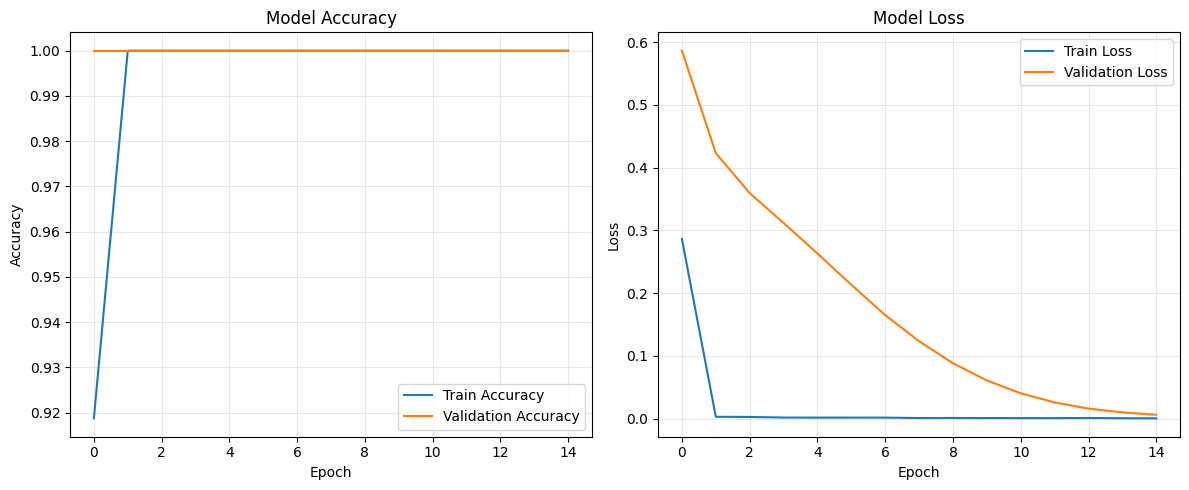

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 1.0000 - loss: 0.0063
Test accuracy: 1.0000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 

Classification Report:
              precision    recall  f1-score   support

     Class_0       1.00      1.00      1.00        41
     Class_1       1.00      1.00      1.00        37
     Class_2       1.00      1.00      1.00        37
     Class_3       1.00      1.00      1.00        47
     Class_4       1.00      1.00      1.00        38

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200



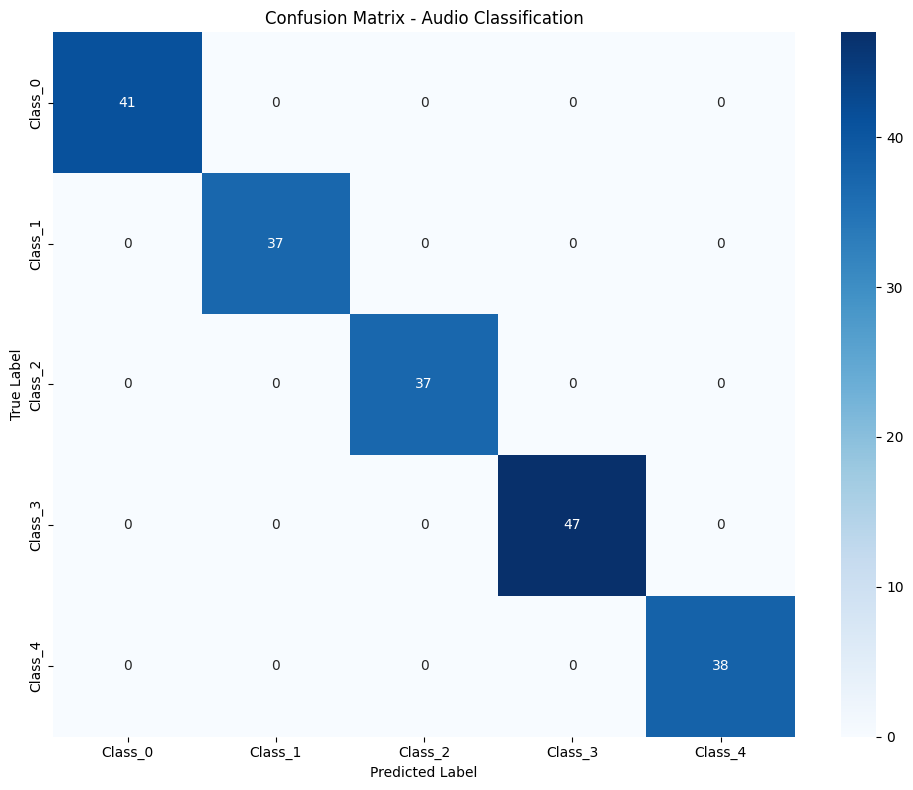


=== Fine-Tuning Approach ===


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 693,253 (2.64 MB)

 Trainable params: 691,461 (2.64 MB)

 Non-trainable params: 1,792 (7.00 KB)

Built model for fine_tuning approach

Training audio classification model...
Epoch 1/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.4145 - loss: 1.5895 - val_accuracy: 1.0000 - val_loss: 1.3941 - learning_rate: 1.0000e-04
Epoch 2/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.9476 - loss: 0.2729 - val_accuracy: 1.0000 - val_loss: 1.2387 - learning_rate: 1.0000e-04
Epoch 3/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.9781 - loss: 0.1362 - val_accuracy: 1.0000 - val_loss: 1.1258 - learning_rate: 1.0000e-04
Epoch 4/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.9993 - loss: 0.0750 - val_accuracy: 1.0000 - val_loss: 1.0257 - learning_rate: 1.0000e-04
Epoch 5/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 1.0000 - loss: 0.0539 - val_accuracy: 1.0000 - val_loss: 0.9275 - learning_rate: 1.0000e-04
Epoch 6/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.9997 - loss: 0.0474 - val_accuracy: 1.0000 - val_loss: 0.8316 - learning_rate: 1.00

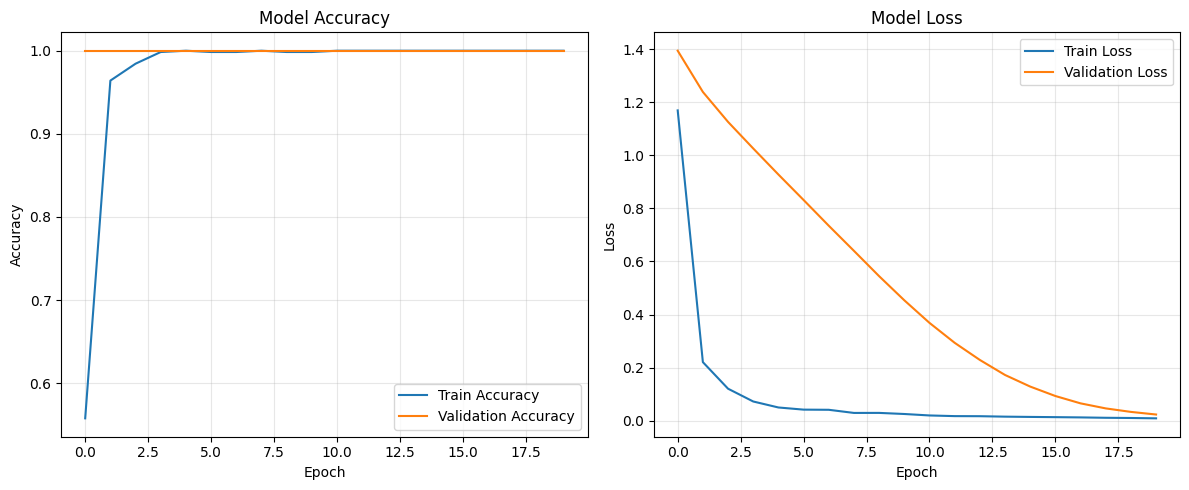

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 1.0000 - loss: 0.0224 
Test accuracy: 1.0000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 

Classification Report:
              precision    recall  f1-score   support

     Class_0       1.00      1.00      1.00        41
     Class_1       1.00      1.00      1.00        37
     Class_2       1.00      1.00      1.00        37
     Class_3       1.00      1.00      1.00        47
     Class_4       1.00      1.00      1.00        38

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200



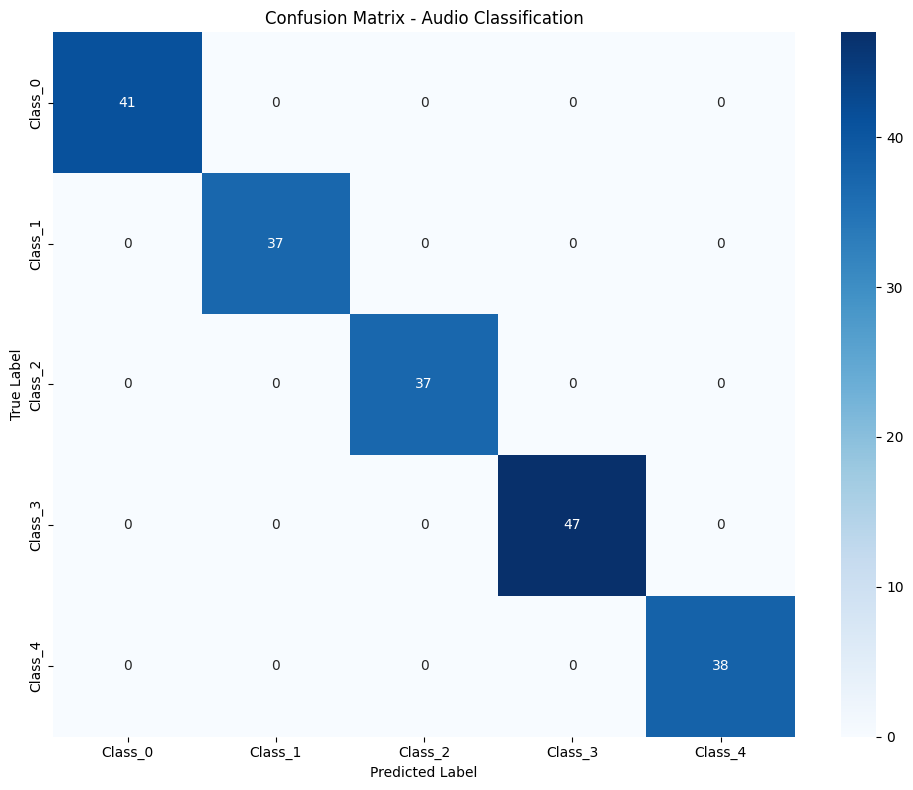

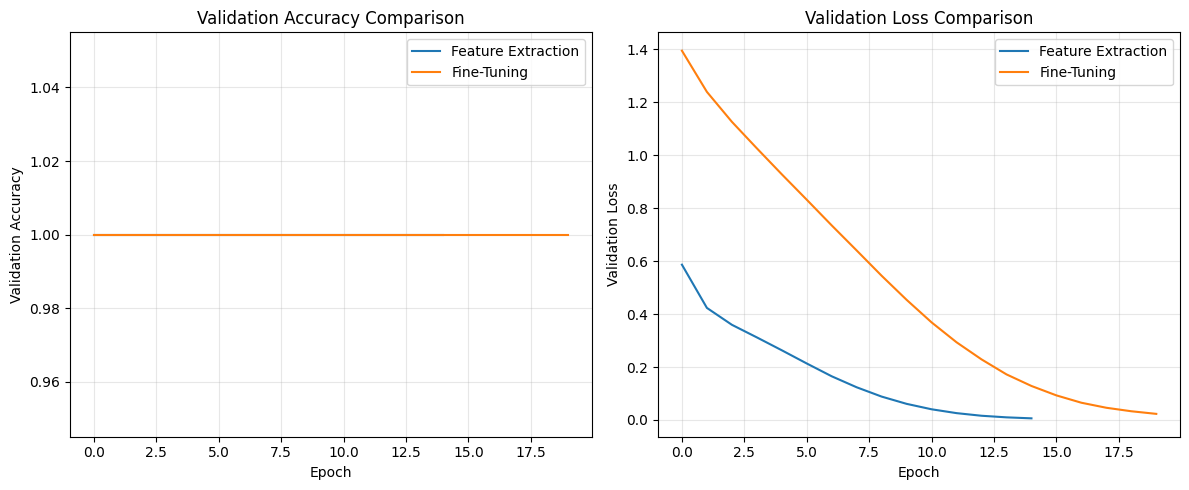


=== Transfer Learning Approaches Comparison ===
Feature Extraction - Best Validation Accuracy: 1.0000, Test Accuracy: 1.0000
Fine-Tuning - Best Validation Accuracy: 1.0000, Test Accuracy: 1.0000
Improvement with Fine-Tuning: 0.00%


In [ ]:
# Run the demonstration
if __name__ == "__main__":
    audio_tl, histories = run_audio_transfer_learning_demo()

### 3. Video Transfer Learning

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Dense, GlobalAveragePooling3D, Input, Conv3D, MaxPooling3D
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow_hub as hub
import cv2
from IPython.display import HTML, display
import time
import glob
from matplotlib import animation
import io
import base64
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
class VideoTransferLearning:
    def __init__(self, input_shape=(16, 112, 112, 3), n_classes=5):
        """Initialize with minimal parameters"""
        self.input_shape = input_shape
        self.n_classes = n_classes

        # Initialize variables
        self.X_train = None
        self.X_test = None
        self.y_train = None
        self.y_test = None
        self.model = None
        self.history = None
        self.class_names = None

        # Load I3D model from TensorFlow Hub
        print("Loading I3D model from TensorFlow Hub...")
        try:
            self.i3d_model = hub.load('https://tfhub.dev/deepmind/i3d-kinetics-400/1')
            print("I3D model loaded successfully!")
        except Exception as e:
            print(f"Error loading I3D model: {e}")
            print("Will implement a custom I3D-like model for demonstration.")
            self.i3d_model = None

    def generate_synthetic_data(self, n_samples=100, test_size=0.2):
        """
        Generate synthetic video data for demonstration

        Fixed to work correctly with proper array initialization
        """
        print("Generating synthetic video data...")

        # Generate synthetic class names
        self.class_names = [f"Action_{i}" for i in range(self.n_classes)]

        # Initialize arrays for data and labels
        X = np.zeros((n_samples, *self.input_shape))

        # Fixed: Properly initialize y as a numpy array
        labels = []  # First use a list for simplicity

        # Generate synthetic video data
        for i in range(n_samples):
            # Assign a random class
            class_idx = i % self.n_classes
            labels.append(class_idx)  # Append to list

            # Create a synthetic "video" with class-specific patterns
            for f in range(self.input_shape[0]):  # For each frame
                # Base pattern: random noise
                frame = np.random.rand(self.input_shape[1], self.input_shape[2], 3) * 0.1

                # Add class-specific pattern - simplified version
                h_center = self.input_shape[1] // 2
                w_center = self.input_shape[2] // 2
                size = min(h_center, w_center) // 3  # Make sure pattern fits in frame

                if class_idx == 0:  # Horizontal movement
                    pos = int((f / self.input_shape[0]) * (self.input_shape[1] - size))
                    frame[h_center-10:h_center+10, pos:pos+size, :] = 0.8

                elif class_idx == 1:  # Vertical movement
                    pos = int((f / self.input_shape[0]) * (self.input_shape[2] - size))
                    frame[pos:pos+size, w_center-10:w_center+10, :] = 0.8

                elif class_idx == 2:  # Diagonal movement
                    pos = int((f / self.input_shape[0]) * (min(self.input_shape[1], self.input_shape[2]) - size))
                    frame[pos:pos+size, pos:pos+size, :] = 0.8

                elif class_idx == 3:  # Circular movement
                    angle = (f / self.input_shape[0]) * 2 * np.pi
                    radius = min(h_center, w_center) - size
                    x = int(w_center + radius * np.cos(angle))
                    y = int(h_center + radius * np.sin(angle))

                    # Ensure within bounds
                    y_start = max(0, y - size//2)
                    y_end = min(self.input_shape[1], y + size//2)
                    x_start = max(0, x - size//2)
                    x_end = min(self.input_shape[2], x + size//2)

                    frame[y_start:y_end, x_start:x_end, :] = 0.8

                else:  # Random static patterns for other classes
                    np.random.seed(class_idx * 100 + f)
                    x = np.random.randint(0, self.input_shape[2] - size)
                    y = np.random.randint(0, self.input_shape[1] - size)
                    frame[y:y+size, x:x+size, :] = 0.8

                X[i, f] = frame

        # Convert labels list to numpy array
        y = np.array(labels)

        # One-hot encode labels
        y_onehot = keras.utils.to_categorical(y, num_classes=self.n_classes)

        # Split into training and test sets
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            X, y_onehot, test_size=test_size, random_state=42, stratify=y
        )

        print(f"Synthetic data generated: {self.X_train.shape[0]} training samples, {self.X_test.shape[0]} test samples")
        print(f"Data shape: {self.X_train.shape}")
        return self.X_train, self.X_test, self.y_train, self.y_test

    def create_i3d_base_model(self, trainable=False):
        """Create a simplified I3D-like model"""
        frames, height, width, channels = self.input_shape

        inputs = Input(shape=self.input_shape)

        # First 3D conv block
        x = Conv3D(64, kernel_size=(3, 7, 7), strides=(1, 2, 2), padding='same', activation='relu')(inputs)
        x = MaxPooling3D(pool_size=(1, 3, 3), strides=(1, 2, 2), padding='same')(x)

        # Second 3D conv block
        x = Conv3D(128, kernel_size=(3, 3, 3), padding='same', activation='relu')(x)
        x = MaxPooling3D(pool_size=(1, 3, 3), strides=(1, 2, 2), padding='same')(x)

        # Third 3D conv block
        x = Conv3D(256, kernel_size=(3, 3, 3), padding='same', activation='relu')(x)
        x = MaxPooling3D(pool_size=(3, 3, 3), strides=(2, 2, 2), padding='same')(x)

        # Global average pooling
        x = GlobalAveragePooling3D()(x)

        # Create model
        model = Model(inputs=inputs, outputs=x)

        # Set layers to non-trainable if feature extraction approach
        if not trainable:
            for layer in model.layers:
                layer.trainable = False

        return model

    def build_feature_extraction_model(self):
        """Build a model using I3D as a feature extractor"""
        print("Building feature extraction model...")

        # Use custom I3D-like model
        base_model = self.create_i3d_base_model(trainable=False)

        # Add classification head
        inputs = keras.Input(shape=self.input_shape)
        x = base_model(inputs)

        # Classification layers
        x = layers.Dense(256, activation='relu')(x)
        x = layers.BatchNormalization()(x)
        x = layers.Dropout(0.5)(x)
        outputs = layers.Dense(self.n_classes, activation='softmax')(x)

        # Create and compile model
        self.model = keras.Model(inputs=inputs, outputs=outputs)

        self.model.compile(
            optimizer=keras.optimizers.Adam(learning_rate=0.001),
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )

        return self.model

    def build_fine_tuning_model(self, freeze_layers_ratio=0.7):
        """Build a model for fine-tuning I3D"""
        print("Building fine-tuning model...")

        # Use custom I3D-like model
        base_model = self.create_i3d_base_model(trainable=True)

        # Freeze early layers
        if freeze_layers_ratio > 0:
            num_layers = len(base_model.layers)
            freeze_layers = int(freeze_layers_ratio * num_layers)

            for layer in base_model.layers[:freeze_layers]:
                layer.trainable = False

        # Add classification head
        inputs = keras.Input(shape=self.input_shape)
        x = base_model(inputs)

        # Classification layers
        x = layers.Dense(256, activation='relu')(x)
        x = layers.BatchNormalization()(x)
        x = layers.Dropout(0.5)(x)
        outputs = layers.Dense(self.n_classes, activation='softmax')(x)

        # Create and compile model
        self.model = keras.Model(inputs=inputs, outputs=outputs)

        # Use a lower learning rate for fine-tuning
        self.model.compile(
            optimizer=keras.optimizers.Adam(learning_rate=0.0001),
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )

        return self.model

    def train(self, epochs=8, batch_size=8, model_type='feature_extraction'):
        """Train the model"""
        # Build appropriate model if not already built
        if self.model is None:
            if model_type == 'feature_extraction':
                self.build_feature_extraction_model()
            elif model_type == 'fine_tuning':
                self.build_fine_tuning_model()
            else:
                raise ValueError("model_type must be either 'feature_extraction' or 'fine_tuning'")

        # Add callbacks
        callbacks = [
            keras.callbacks.EarlyStopping(
                monitor='val_loss', patience=3, restore_best_weights=True, verbose=1
            )
        ]

        # Train the model
        print(f"\nTraining video classification model ({model_type})...")
        self.history = self.model.fit(
            self.X_train, self.y_train,
            epochs=epochs,
            batch_size=batch_size,
            validation_split=0.2,
            callbacks=callbacks,
            verbose=1
        )

        return self.history

    def evaluate(self):
        """Evaluate the model on test data"""
        # Evaluate the model
        test_loss, test_acc = self.model.evaluate(self.X_test, self.y_test, verbose=1)
        print(f"Test accuracy: {test_acc:.4f}")

        # Get predictions
        y_pred = self.model.predict(self.X_test)
        y_pred_classes = np.argmax(y_pred, axis=1)
        y_true_classes = np.argmax(self.y_test, axis=1)

        # Compute confusion matrix
        cm = confusion_matrix(y_true_classes, y_pred_classes)

        return test_acc, cm, y_pred_classes, y_true_classes

    def visualize_training_history(self):
        """Visualize the training history"""
        if self.history is None:
            print("Model has not been trained yet.")
            return

        # Plotting training history
        plt.figure(figsize=(12, 5))

        # Plot accuracy
        plt.subplot(1, 2, 1)
        plt.plot(self.history.history['accuracy'], label='Train Accuracy')
        plt.plot(self.history.history['val_accuracy'], label='Validation Accuracy')
        plt.title('Model Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend(loc='lower right')
        plt.grid(True, alpha=0.3)

        # Plot loss
        plt.subplot(1, 2, 2)
        plt.plot(self.history.history['loss'], label='Train Loss')
        plt.plot(self.history.history['val_loss'], label='Validation Loss')
        plt.title('Model Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend(loc='upper right')
        plt.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

    def visualize_confusion_matrix(self):
        """Visualize the confusion matrix"""
        # Evaluate on test data
        _, cm, _, _ = self.evaluate()

        # Plot confusion matrix
        plt.figure(figsize=(8, 6))
        plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
        plt.title('Confusion Matrix')
        plt.colorbar()

        # Add labels
        tick_marks = np.arange(len(self.class_names))
        plt.xticks(tick_marks, self.class_names, rotation=45)
        plt.yticks(tick_marks, self.class_names)

        # Add text annotations
        thresh = cm.max() / 2.
        for i in range(cm.shape[0]):
            for j in range(cm.shape[1]):
                plt.text(j, i, format(cm[i, j], 'd'),
                        horizontalalignment="center",
                        color="white" if cm[i, j] > thresh else "black")

        plt.tight_layout()
        plt.ylabel('True label')
        plt.xlabel('Predicted label')
        plt.show()

In [ ]:
# Function to demonstrate the Video Transfer Learning pipeline
def run_video_transfer_learning_demo():
    """Demonstrate video transfer learning with both approaches"""
    print("Starting Video Transfer Learning Demo")

    # Initialize with smaller input shape for faster computation
    input_shape = (16, 64, 64, 3)  # Even smaller for quick demonstration
    n_classes = 5

    video_tl = VideoTransferLearning(
        input_shape=input_shape,
        n_classes=n_classes
    )

    # Generate synthetic data
    X_train, X_test, y_train, y_test = video_tl.generate_synthetic_data(n_samples=80, test_size=0.2)

    # Compare both transfer learning approaches
    histories = {}

    # 1. Feature Extraction Approach
    print("\n=== Feature Extraction Approach ===")
    model_fe = video_tl.build_feature_extraction_model()
    history_fe = video_tl.train(epochs=6, batch_size=8, model_type='feature_extraction')
    fe_acc, _, _, _ = video_tl.evaluate()
    video_tl.visualize_training_history()
    video_tl.visualize_confusion_matrix()

    # Store history for comparison
    histories['feature_extraction'] = history_fe
    fe_val_acc = max(history_fe.history['val_accuracy'])

    # 2. Fine-Tuning Approach
    print("\n=== Fine-Tuning Approach ===")
    model_ft = video_tl.build_fine_tuning_model(freeze_layers_ratio=0.7)
    history_ft = video_tl.train(epochs=8, batch_size=8, model_type='fine_tuning')
    ft_acc, _, _, _ = video_tl.evaluate()
    video_tl.visualize_training_history()
    video_tl.visualize_confusion_matrix()

    # Store history for comparison
    histories['fine_tuning'] = history_ft
    ft_val_acc = max(history_ft.history['val_accuracy'])

    # Compare the two approaches
    plt.figure(figsize=(12, 5))

    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(histories['feature_extraction'].history['val_accuracy'], label='Feature Extraction')
    plt.plot(histories['fine_tuning'].history['val_accuracy'], label='Fine-Tuning')
    plt.title('Validation Accuracy Comparison')
    plt.xlabel('Epoch')
    plt.ylabel('Validation Accuracy')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(histories['feature_extraction'].history['val_loss'], label='Feature Extraction')
    plt.plot(histories['fine_tuning'].history['val_loss'], label='Fine-Tuning')
    plt.title('Validation Loss Comparison')
    plt.xlabel('Epoch')
    plt.ylabel('Validation Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Print comparison summary
    print("\n=== Transfer Learning Approaches Comparison ===")
    print(f"Feature Extraction - Best Validation Accuracy: {fe_val_acc:.4f}, Test Accuracy: {fe_acc:.4f}")
    print(f"Fine-Tuning - Best Validation Accuracy: {ft_val_acc:.4f}, Test Accuracy: {ft_acc:.4f}")
    print(f"Improvement with Fine-Tuning: {(ft_acc - fe_acc) * 100:.2f}%")

    return video_tl, histories

Starting Video Transfer Learning Demo
Loading I3D model from TensorFlow Hub...
I3D model loaded successfully!
Generating synthetic video data...
Synthetic data generated: 64 training samples, 16 test samples
Data shape: (64, 16, 64, 64, 3)

=== Feature Extraction Approach ===
Building feature extraction model...

Training video classification model (feature_extraction)...
Epoch 1/6
7/7 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.4166 - loss: 1.4689 - val_accuracy: 0.1538 - val_loss: 1.5926
Epoch 2/6
7/7 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.9296 - loss: 0.8885 - val_accuracy: 0.1538 - val_loss: 1.5857
Epoch 3/6
7/7 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.9925 - loss: 0.5870 - val_accuracy: 0.1538 - val_loss: 1.5824
Epoch 4/6
7/7 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 1.0000 - loss: 0.4097 - val_accuracy: 0.1538 - val_loss: 1.5794
Epoch 5/6
7/7 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 1.0000 - loss: 0.3174 - val_accuracy: 0.5385 - val_loss: 1.5780
Epoch 6/6
7

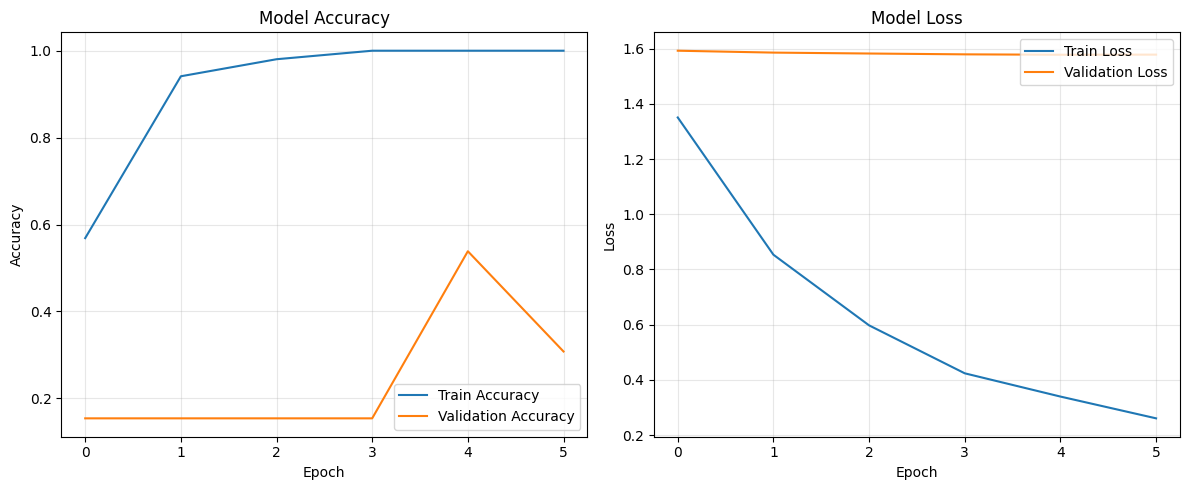

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.5625 - loss: 1.6128
Test accuracy: 0.5625
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


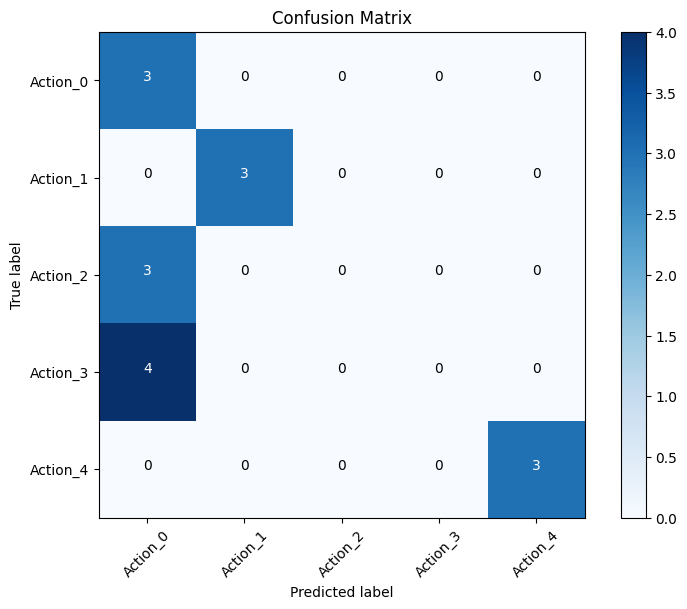


=== Fine-Tuning Approach ===
Building fine-tuning model...

Training video classification model (fine_tuning)...
Epoch 1/8
7/7 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - accuracy: 0.5006 - loss: 1.4720 - val_accuracy: 0.3077 - val_loss: 1.5839
Epoch 2/8
7/7 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step - accuracy: 1.0000 - loss: 0.8705 - val_accuracy: 0.3077 - val_loss: 1.5601
Epoch 3/8
7/7 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 1.0000 - loss: 0.5188 - val_accuracy: 0.3077 - val_loss: 1.5392
Epoch 4/8
7/7 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 1.0000 - loss: 0.3110 - val_accuracy: 0.6154 - val_loss: 1.5157
Epoch 5/8
7/7 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - accuracy: 1.0000 - loss: 0.2360 - val_accuracy: 0.6154 - val_loss: 1.4974
Epoch 6/8
7/7 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - accuracy: 1.0000 - loss: 0.1828 - val_accuracy: 0.6154 - val_loss: 1.4800
Epoch 7/8
7/7 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - accuracy: 1.0000 - loss: 0.1278 - val_accuracy: 0.6154 - val_loss: 1.4654
Epoch 8/8
7/7 ━━━━━━━━━━━

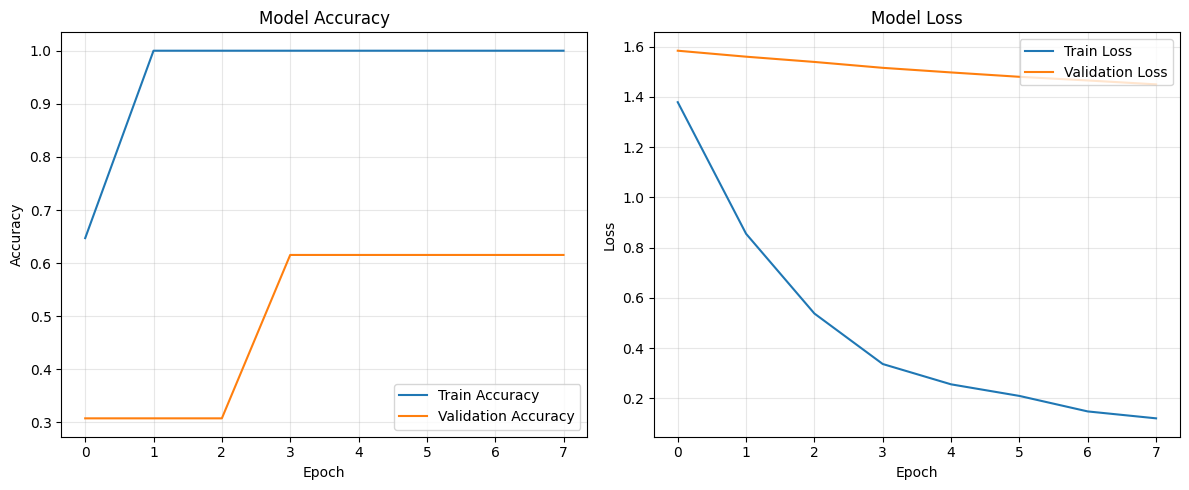

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.5625 - loss: 1.4658
Test accuracy: 0.5625
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


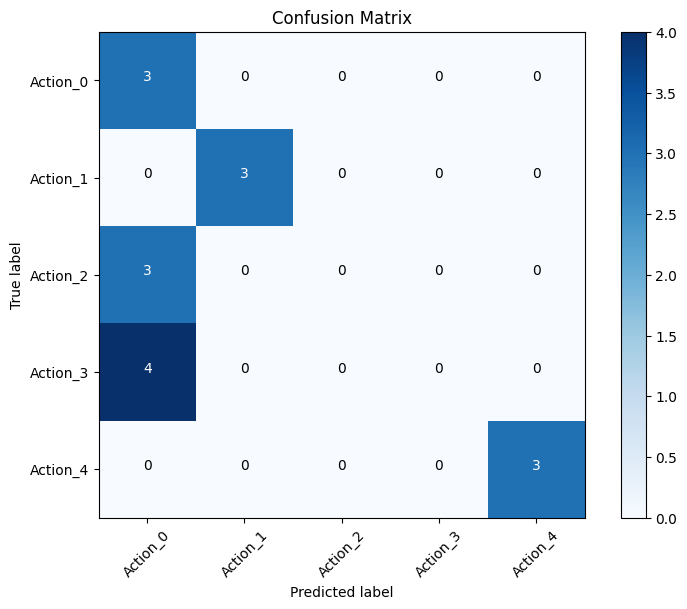

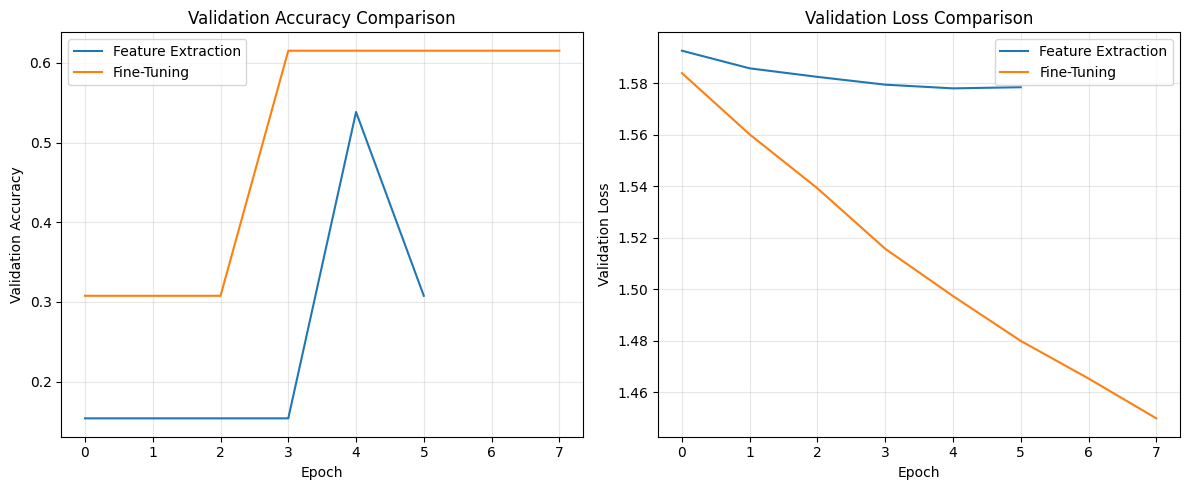


=== Transfer Learning Approaches Comparison ===
Feature Extraction - Best Validation Accuracy: 0.5385, Test Accuracy: 0.5625
Fine-Tuning - Best Validation Accuracy: 0.6154, Test Accuracy: 0.5625
Improvement with Fine-Tuning: 0.00%


In [ ]:
# Run the demonstration
if __name__ == "__main__":
    video_tl, histories = run_video_transfer_learning_demo()

### 4. NLP Transfer Learning

In [ ]:
!pip install -q tensorflow tensorflow-hub tensorflow-text

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow_hub as hub
import tensorflow_text  # Required for BERT preprocessing
import time

In [ ]:
# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)


In [ ]:
print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.18.0


In [ ]:
class NLPTransferLearning:
    def __init__(self, max_seq_length=128):
        """
        Initialize the NLP Transfer Learning class

        Parameters:
        -----------
        max_seq_length : int
            Maximum sequence length for BERT tokenization
        """
        self.max_seq_length = max_seq_length

        # Initialize variables
        self.X_train = None
        self.X_test = None
        self.y_train = None
        self.y_test = None
        self.model = None
        self.history = None
        self.class_names = None
        self.n_classes = None

        # Load Universal Sentence Encoder and BERT preprocessor
        print("Loading pre-trained models...")
        try:
            # Load Universal Sentence Encoder
            print("Loading Universal Sentence Encoder...")
            self.use_model = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")
            print("Universal Sentence Encoder loaded successfully!")

            # Load BERT preprocessor and encoder
            print("Loading BERT models...")
            self.bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
            self.bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/2")
            print("BERT models loaded successfully!")
        except Exception as e:
            print(f"Error loading pre-trained models: {e}")
            print("Some functionality might be limited.")

    def generate_sample_data(self, n_samples=1000, test_size=0.2):
        """
        Generate sample text data for sentiment analysis

        Parameters:
        -----------
        n_samples : int
            Number of samples to generate
        test_size : float
            Proportion of data to use for testing

        Returns:
        --------
        X_train, X_test, y_train, y_test : numpy arrays
            Training and test data
        """
        print("Generating sample sentiment analysis data...")

        # Set number of classes (positive/negative/neutral)
        self.n_classes = 3
        self.class_names = ['Negative', 'Neutral', 'Positive']

        # Templates for generating synthetic sentiment data
        positive_templates = [
            "I really enjoyed {item}, it was {positive_adj}.",
            "The {item} was {positive_adj} and {positive_adj}.",
            "I had a wonderful experience with {item}.",
            "The {item} exceeded my expectations in every way.",
            "I'm very satisfied with my {item} purchase.",
            "{item} is definitely worth the price.",
            "I would highly recommend {item} to anyone.",
            "This is the best {item} I've ever used.",
            "I love how {positive_adj} the {item} is.",
            "The {item} works perfectly and is very {positive_adj}."
        ]

        neutral_templates = [
            "The {item} was average, nothing special.",
            "I have mixed feelings about the {item}.",
            "The {item} was okay but not great.",
            "I neither liked nor disliked the {item}.",
            "The {item} met basic expectations.",
            "I'm undecided about whether to recommend the {item}.",
            "The {item} has both good and bad features.",
            "The {item} was somewhat {positive_adj} but also {negative_adj}.",
            "I don't have strong feelings about the {item}.",
            "The {item} was just alright."
        ]

        negative_templates = [
            "I really disliked the {item}, it was {negative_adj}.",
            "The {item} was {negative_adj} and {negative_adj}.",
            "I had a terrible experience with the {item}.",
            "The {item} fell short of my expectations.",
            "I'm very dissatisfied with my {item} purchase.",
            "The {item} is definitely not worth the price.",
            "I would not recommend the {item} to anyone.",
            "This is the worst {item} I've ever used.",
            "I hate how {negative_adj} the {item} is.",
            "The {item} doesn't work properly and is very {negative_adj}."
        ]

        items = [
            "product", "phone", "laptop", "service", "restaurant", "movie",
            "book", "hotel", "car", "experience", "meal", "show", "app",
            "game", "camera", "headphones", "software", "tablet", "TV", "speaker"
        ]

        positive_adjectives = [
            "excellent", "amazing", "fantastic", "great", "awesome",
            "wonderful", "superb", "outstanding", "impressive", "exceptional",
            "high-quality", "reliable", "brilliant", "delightful", "perfect"
        ]

        negative_adjectives = [
            "terrible", "awful", "horrible", "poor", "bad",
            "disappointing", "frustrating", "useless", "defective", "subpar",
            "low-quality", "unreliable", "mediocre", "annoying", "dreadful"
        ]

        # Generate synthetic data
        texts = []
        labels = []

        for i in range(n_samples):
            # Select sentiment class
            label = i % self.n_classes  # 0: negative, 1: neutral, 2: positive

            if label == 0:  # Negative
                template = np.random.choice(negative_templates)
                item = np.random.choice(items)
                adj1 = np.random.choice(negative_adjectives)
                adj2 = np.random.choice(negative_adjectives)
                text = template.format(item=item, negative_adj=adj1, positive_adj=adj2)
            elif label == 1:  # Neutral
                template = np.random.choice(neutral_templates)
                item = np.random.choice(items)
                pos_adj = np.random.choice(positive_adjectives)
                neg_adj = np.random.choice(negative_adjectives)
                text = template.format(item=item, positive_adj=pos_adj, negative_adj=neg_adj)
            else:  # Positive
                template = np.random.choice(positive_templates)
                item = np.random.choice(items)
                adj1 = np.random.choice(positive_adjectives)
                adj2 = np.random.choice(positive_adjectives)
                text = template.format(item=item, positive_adj=adj1, negative_adj=adj2)

            texts.append(text)
            labels.append(label)

        # Convert to numpy arrays
        texts = np.array(texts)
        labels = np.array(labels)

        # Split into training and test sets
        X_train, X_test, y_train, y_test = train_test_split(
            texts, labels, test_size=test_size, random_state=42, stratify=labels
        )

        # One-hot encode labels
        y_train = keras.utils.to_categorical(y_train, num_classes=self.n_classes)
        y_test = keras.utils.to_categorical(y_test, num_classes=self.n_classes)

        self.X_train = X_train
        self.X_test = X_test
        self.y_train = y_train
        self.y_test = y_test

        print(f"Sample data generated: {len(X_train)} training samples, {len(X_test)} test samples")
        return X_train, X_test, y_train, y_test

    def get_use_embeddings(self, texts):
        """
        Get Universal Sentence Encoder embeddings for texts

        Parameters:
        -----------
        texts : array-like
            Array of text strings

        Returns:
        --------
        embeddings : numpy array
            USE embeddings for the input texts
        """
        return self.use_model(texts).numpy()

    def train_use_model(self, dropout_rate=0.2, epochs=5, batch_size=32):
        """
        Train a model using Universal Sentence Encoder embeddings

        Parameters:
        -----------
        dropout_rate : float
            Dropout rate for regularization
        epochs : int
            Number of training epochs
        batch_size : int
            Batch size for training

        Returns:
        --------
        history : History object
            Training history
        """
        print("Building and training Universal Sentence Encoder model...")

        # Get embeddings for training data
        print("Getting USE embeddings for training data...")
        start_time = time.time()
        train_embeddings = self.get_use_embeddings(self.X_train)
        embedding_time = time.time() - start_time
        print(f"Embedding time: {embedding_time:.2f} seconds")
        print(f"Embedding dimension: {train_embeddings.shape[1]}")

        # Get embeddings for test data
        print("Getting USE embeddings for test data...")
        test_embeddings = self.get_use_embeddings(self.X_test)

        # Create model
        start_time = time.time()

        # Get embedding dimension
        embedding_dim = train_embeddings.shape[1]

        # Create model
        inputs = layers.Input(shape=(embedding_dim,), dtype=tf.float32)
        x = layers.Dense(128, activation='relu')(inputs)
        x = layers.BatchNormalization()(x)
        x = layers.Dropout(dropout_rate)(x)
        x = layers.Dense(64, activation='relu')(x)
        x = layers.BatchNormalization()(x)
        x = layers.Dropout(dropout_rate)(x)
        outputs = layers.Dense(self.n_classes, activation='softmax')(x)

        model = keras.Model(inputs=inputs, outputs=outputs)

        # Compile model
        model.compile(
            optimizer=keras.optimizers.Adam(learning_rate=0.001),
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )

        # Print model summary
        model.summary()

        # Add callbacks
        callbacks = [
            keras.callbacks.EarlyStopping(
                monitor='val_loss', patience=3, restore_best_weights=True
            )
        ]

        # Train the model
        print("Training Universal Sentence Encoder model...")
        history = model.fit(
            train_embeddings, self.y_train,
            epochs=epochs,
            batch_size=batch_size,
            validation_data=(test_embeddings, self.y_test),
            callbacks=callbacks,
            verbose=1
        )

        training_time = time.time() - start_time
        print(f"Training time: {training_time:.2f} seconds")

        # Evaluate the model
        test_loss, test_acc = model.evaluate(test_embeddings, self.y_test, verbose=1)
        print(f"Test accuracy: {test_acc:.4f}")

        # Store model and history
        self.model = model
        self.history = history
        self.model_type = 'use'

        # Store embeddings for later use
        self.train_embeddings = train_embeddings
        self.test_embeddings = test_embeddings

        return history, test_acc, training_time

    def train_bert_feature_extraction(self, dropout_rate=0.1, epochs=3, batch_size=16):
        """Train a model using BERT for feature extraction (frozen BERT layers)"""
        print("Building and training BERT feature extraction model...")

        start_time = time.time()

        # Build the model
        text_input = layers.Input(shape=(), dtype=tf.string, name='text_input')

        # Apply BERT preprocessor on text
        encoder_inputs = self.bert_preprocess(text_input)

        # Apply BERT model with frozen weights
        bert_output = self.bert_encoder(encoder_inputs)

        # Extract the pooled output for classification
        pooled_output = bert_output['pooled_output']

        # Add classification layers
        x = layers.Dropout(dropout_rate)(pooled_output)
        x = layers.Dense(128, activation='relu')(x)
        x = layers.BatchNormalization()(x)
        x = layers.Dropout(dropout_rate)(x)
        outputs = layers.Dense(self.n_classes, activation='softmax')(x)

        # Build the model
        model = keras.Model(inputs=text_input, outputs=outputs)

        # Make BERT encoder layer non-trainable (feature extraction)
        self.bert_encoder.trainable = False

        # Compile the model
        model.compile(
            optimizer=keras.optimizers.Adam(learning_rate=2e-5),
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )

        # Print model summary
        model.summary()

        # Add callbacks
        callbacks = [
            keras.callbacks.EarlyStopping(
                monitor='val_loss', patience=2, restore_best_weights=True
            )
        ]

        # Train the model
        print("Training BERT feature extraction model...")
        history = model.fit(
            self.X_train, self.y_train,
            epochs=epochs,
            batch_size=batch_size,
            validation_data=(self.X_test, self.y_test),
            callbacks=callbacks,
            verbose=1
        )

        training_time = time.time() - start_time
        print(f"Training time: {training_time:.2f} seconds")

        # Evaluate the model
        test_loss, test_acc = model.evaluate(self.X_test, self.y_test, verbose=1)
        print(f"Test accuracy: {test_acc:.4f}")

        # Store model and history
        self.model = model
        self.history = history
        self.model_type = 'bert_feature_extraction'

        return history, test_acc, training_time

    def train_bert_fine_tuning(self, dropout_rate=0.1, epochs=3, batch_size=16):
        print("Building and training BERT fine-tuning model...")

        start_time = time.time()

        # Build the model
        text_input = layers.Input(shape=(), dtype=tf.string, name='text_input')

        # Apply BERT preprocessor on text
        encoder_inputs = self.bert_preprocess(text_input)

        # Apply BERT model with trainable weights
        bert_output = self.bert_encoder(encoder_inputs)

        # Extract the pooled output for classification
        pooled_output = bert_output['pooled_output']

        # Add simple classification layers for fine-tuning
        x = layers.Dropout(dropout_rate)(pooled_output)
        outputs = layers.Dense(self.n_classes, activation='softmax')(x)

        # Build the model
        model = keras.Model(inputs=text_input, outputs=outputs)

        # Make BERT encoder trainable (fine-tuning)
        self.bert_encoder.trainable = True

        # Lower learning rate for fine-tuning
        model.compile(
            optimizer=keras.optimizers.Adam(learning_rate=3e-5),
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )

        # Print model summary
        model.summary()

        # Add callbacks
        callbacks = [
            keras.callbacks.EarlyStopping(
                monitor='val_loss', patience=2, restore_best_weights=True
            )
        ]

        # Train the model
        print("Training BERT fine-tuning model...")
        history = model.fit(
            self.X_train, self.y_train,
            epochs=epochs,
            batch_size=batch_size,
            validation_data=(self.X_test, self.y_test),
            callbacks=callbacks,
            verbose=1
        )

        training_time = time.time() - start_time
        print(f"Training time: {training_time:.2f} seconds")

        # Evaluate the model
        test_loss, test_acc = model.evaluate(self.X_test, self.y_test, verbose=1)
        print(f"Test accuracy: {test_acc:.4f}")

        # Store model and history
        self.model = model
        self.history = history
        self.model_type = 'bert_fine_tuning'

        return history, test_acc, training_time

    def visualize_training_history(self):
        """
        Visualize the training history
        """
        if self.history is None:
            print("Model has not been trained yet.")
            return

        # Plotting training history
        plt.figure(figsize=(12, 5))

        # Plot accuracy
        plt.subplot(1, 2, 1)
        plt.plot(self.history.history['accuracy'], label='Train Accuracy')
        plt.plot(self.history.history['val_accuracy'], label='Validation Accuracy')
        plt.title('Model Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend(loc='lower right')
        plt.grid(True, alpha=0.3)

        # Plot loss
        plt.subplot(1, 2, 2)
        plt.plot(self.history.history['loss'], label='Train Loss')
        plt.plot(self.history.history['val_loss'], label='Validation Loss')
        plt.title('Model Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend(loc='upper right')
        plt.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

    def visualize_confusion_matrix(self):
        """
        Visualize the confusion matrix
        """
        if not hasattr(self, 'model') or self.model is None:
            print("No model to evaluate. Train a model first.")
            return

        # For USE model, we need to get embeddings first
        if self.model_type == 'use':
            # Get predictions
            y_pred = self.model.predict(self.test_embeddings)
        else:  # BERT models
            # Get predictions
            y_pred = self.model.predict(self.X_test)

        # Get predicted and true classes
        y_pred_classes = np.argmax(y_pred, axis=1)
        y_true_classes = np.argmax(self.y_test, axis=1)

        # Compute confusion matrix
        cm = confusion_matrix(y_true_classes, y_pred_classes)

        # Plot confusion matrix
        plt.figure(figsize=(8, 6))
        plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
        plt.title('Confusion Matrix')
        plt.colorbar()

        # Add labels
        tick_marks = np.arange(len(self.class_names))
        plt.xticks(tick_marks, self.class_names, rotation=45)
        plt.yticks(tick_marks, self.class_names)

        # Add text annotations
        thresh = cm.max() / 2.
        for i in range(cm.shape[0]):
            for j in range(cm.shape[1]):
                plt.text(j, i, format(cm[i, j], 'd'),
                        horizontalalignment="center",
                        color="white" if cm[i, j] > thresh else "black")

        plt.tight_layout()
        plt.ylabel('True label')
        plt.xlabel('Predicted label')
        plt.show()

        # Print classification report
        print("\nClassification Report:")
        print(classification_report(y_true_classes, y_pred_classes,
                                   target_names=self.class_names))

    def predict_sentiment(self, texts):
        """
        Predict sentiment for new texts

        Parameters:
        -----------
        texts : list of str
            List of texts to predict sentiment for

        Returns:
        --------
        predictions : numpy array
            Predicted sentiment classes (0: negative, 1: neutral, 2: positive)
        confidence : numpy array
            Confidence scores for predictions
        """
        if not hasattr(self, 'model') or self.model is None:
            print("No model to predict with. Train a model first.")
            return None, None

        if not isinstance(texts, list):
            texts = [texts]

        # For USE model, we need to get embeddings first
        if self.model_type == 'use':
            # Get embeddings
            embeddings = self.get_use_embeddings(texts)
            # Get predictions
            predictions = self.model.predict(embeddings)
        else:  # BERT models
            # Get predictions directly
            predictions = self.model.predict(np.array(texts))

        # Get predicted classes and confidence
        predicted_classes = np.argmax(predictions, axis=1)
        confidence = np.max(predictions, axis=1)

        # Print results
        print("\nPrediction Results:")
        for i, (text, pred_class, conf) in enumerate(zip(texts, predicted_classes, confidence)):
            class_name = self.class_names[pred_class] if self.class_names else f"Class {pred_class}"
            print(f"Text {i+1}: \"{text}\"")
            print(f"Predicted sentiment: {class_name} (confidence: {conf:.4f})")
            print()

        return predicted_classes, confidence

In [ ]:
# Function to run NLP transfer learning demo with all models
def run_nlp_transfer_learning_demo():
    """
    Demonstrate NLP transfer learning with all three approaches:
    1. Universal Sentence Encoder for feature extraction
    2. BERT for feature extraction
    3. BERT for fine-tuning

    Compares performance, training time, and accuracy across all models.
    """
    print("Starting NLP Transfer Learning Demo")

    # Initialize the NLP Transfer Learning class
    nlp_tl = NLPTransferLearning()

    # Generate sample data
    X_train, X_test, y_train, y_test = nlp_tl.generate_sample_data(n_samples=600, test_size=0.2)

    # Dictionary to store results
    results = {
        'model': [],
        'test_accuracy': [],
        'training_time': []
    }

    # 1. Universal Sentence Encoder Model
    print("\n=== Universal Sentence Encoder for Feature Extraction ===")
    use_history, use_acc, use_time = nlp_tl.train_use_model(epochs=5, batch_size=32)
    nlp_tl.visualize_training_history()
    nlp_tl.visualize_confusion_matrix()

    # Store results
    results['model'].append('Universal Sentence Encoder')
    results['test_accuracy'].append(use_acc)
    results['training_time'].append(use_time)

    # 2. BERT Feature Extraction Model
    print("\n=== BERT for Feature Extraction ===")
    bert_fe_history, bert_fe_acc, bert_fe_time = nlp_tl.train_bert_feature_extraction(epochs=3, batch_size=16)
    nlp_tl.visualize_training_history()
    nlp_tl.visualize_confusion_matrix()

    # Store results
    results['model'].append('BERT Feature Extraction')
    results['test_accuracy'].append(bert_fe_acc)
    results['training_time'].append(bert_fe_time)

    # 3. BERT Fine-Tuning Model
    print("\n=== BERT for Fine-Tuning ===")
    bert_ft_history, bert_ft_acc, bert_ft_time = nlp_tl.train_bert_fine_tuning(epochs=3, batch_size=16)
    nlp_tl.visualize_training_history()
    nlp_tl.visualize_confusion_matrix()

    # Store results
    results['model'].append('BERT Fine-Tuning')
    results['test_accuracy'].append(bert_ft_acc)
    results['training_time'].append(bert_ft_time)

    # Convert results to DataFrame for easier visualization
    results_df = pd.DataFrame(results)
    print("\n=== Model Comparison ===")
    print(results_df)

    # Plot accuracy comparison
    plt.figure(figsize=(14, 6))

    # Plot accuracy vs. time
    plt.subplot(1, 2, 1)
    plt.bar(results['model'], results['test_accuracy'], color=['#3498db', '#2ecc71', '#e74c3c'])
    plt.title('Model Accuracy Comparison')
    plt.ylabel('Test Accuracy')
    plt.ylim([0, 1.0])
    plt.xticks(rotation=45, ha='right')

    # Add accuracy values on top of bars
    for i, acc in enumerate(results['test_accuracy']):
        plt.text(i, acc + 0.02, f'{acc:.4f}', ha='center', va='bottom')

    # Plot training time
    plt.subplot(1, 2, 2)
    plt.bar(results['model'], results['training_time'], color=['#3498db', '#2ecc71', '#e74c3c'])
    plt.title('Training Time Comparison')
    plt.ylabel('Time (seconds)')
    plt.xticks(rotation=45, ha='right')

    # Add time values on top of bars
    for i, t in enumerate(results['training_time']):
        plt.text(i, t + 1, f'{t:.1f}s', ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

    # Test on some examples
    test_texts = [
        "I absolutely loved this product, it exceeded all my expectations!",
        "The service was okay, nothing special.",
        "This was a terrible experience, I would never recommend it to anyone."
    ]

    # Predictions with the last trained model (BERT Fine-Tuning)
    print("\n=== Sample Predictions ===")
    nlp_tl.predict_sentiment(test_texts)

    return nlp_tl, results_df

Starting NLP Transfer Learning Demo
Loading pre-trained models...
Loading Universal Sentence Encoder...
Universal Sentence Encoder loaded successfully!
Loading BERT models...
BERT models loaded successfully!
Generating sample sentiment analysis data...
Sample data generated: 480 training samples, 120 test samples

=== Universal Sentence Encoder for Feature Extraction ===
Building and training Universal Sentence Encoder model...
Getting USE embeddings for training data...
Embedding time: 0.63 seconds
Embedding dimension: 512
Getting USE embeddings for test data...


Model: "functional_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_12 (InputLayer)     │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_20          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 74,883 (292.51 KB)

 Trainable params: 74,499 (291.01 KB)

 Non-trainable params: 384 (1.50 KB)

Training Universal Sentence Encoder model...
Epoch 1/5
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.5618 - loss: 0.9929 - val_accuracy: 0.8500 - val_loss: 1.0369
Epoch 2/5
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9558 - loss: 0.1645 - val_accuracy: 0.8917 - val_loss: 0.9839
Epoch 3/5
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9850 - loss: 0.0728 - val_accuracy: 0.9417 - val_loss: 0.9441
Epoch 4/5
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9993 - loss: 0.0442 - val_accuracy: 0.9583 - val_loss: 0.9080
Epoch 5/5
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9825 - loss: 0.0520 - val_accuracy: 0.9833 - val_loss: 0.8679
Training time: 4.42 seconds
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9860 - loss: 0.8687
Test accuracy: 0.9833


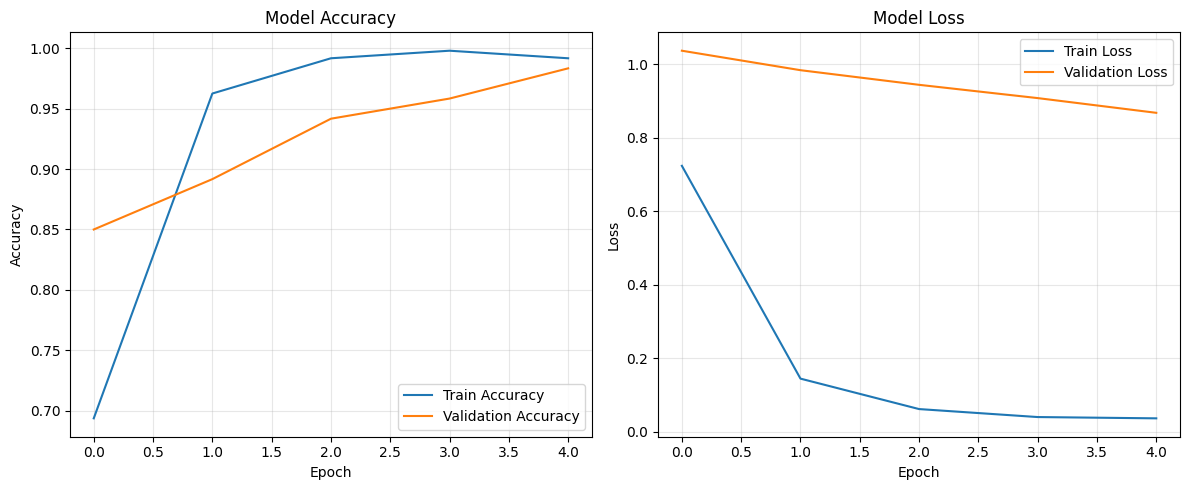

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


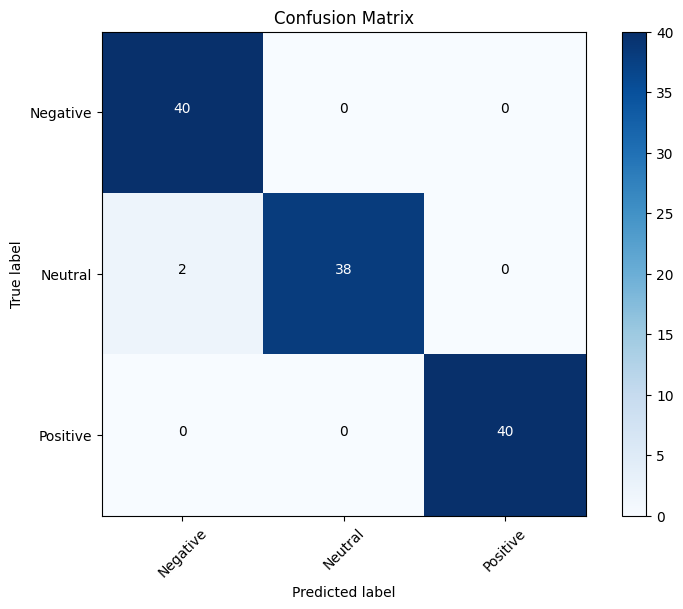


Classification Report:
              precision    recall  f1-score   support

    Negative       0.95      1.00      0.98        40
     Neutral       1.00      0.95      0.97        40
    Positive       1.00      1.00      1.00        40

    accuracy                           0.98       120
   macro avg       0.98      0.98      0.98       120
weighted avg       0.98      0.98      0.98       120


=== BERT for Feature Extraction ===
Building and training BERT feature extraction model...


ValueError: Exception encountered when calling layer 'keras_layer_6' (type KerasLayer).

A KerasTensor is symbolic: it's a placeholder for a shape an a dtype. It doesn't have any actual numerical value. You cannot convert it to a NumPy array.

Call arguments received by layer 'keras_layer_6' (type KerasLayer):
  • inputs=<KerasTensor shape=(None,), dtype=string, sparse=False, name=text_input>
  • training=None

In [ ]:
# Run the demonstration when the script is executed
if __name__ == "__main__":
    nlp_tl, results_df = run_nlp_transfer_learning_demo()

TensorFlow version: 2.18.0
Starting NLP Transfer Learning Demo
Loading pre-trained models...
Loading Universal Sentence Encoder...
Universal Sentence Encoder loaded successfully!
Loading BERT models...
BERT models loaded successfully!
Generating sample sentiment analysis data...
Sample data generated: 480 training samples, 120 test samples

=== Universal Sentence Encoder for Feature Extraction ===
Building and training Universal Sentence Encoder model...
Getting USE embeddings for training data...
Embedding time: 0.43 seconds
Embedding dimension: 512
Getting USE embeddings for test data...


Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_13 (InputLayer)     │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_21          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_22          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 74,883 (292.51 KB)

 Trainable params: 74,499 (291.01 KB)

 Non-trainable params: 384 (1.50 KB)

Training Universal Sentence Encoder model...
Epoch 1/5
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.5111 - loss: 1.1925 - val_accuracy: 0.6250 - val_loss: 1.0357
Epoch 2/5
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.9577 - loss: 0.1742 - val_accuracy: 0.3917 - val_loss: 0.9959
Epoch 3/5
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9910 - loss: 0.0706 - val_accuracy: 0.3417 - val_loss: 0.9701
Epoch 4/5
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 1.0000 - loss: 0.0496 - val_accuracy: 0.3417 - val_loss: 0.9525
Epoch 5/5
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9997 - loss: 0.0285 - val_accuracy: 0.3417 - val_loss: 0.9408
Training time: 5.16 seconds
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.3262 - loss: 0.9499
Test accuracy: 0.3417


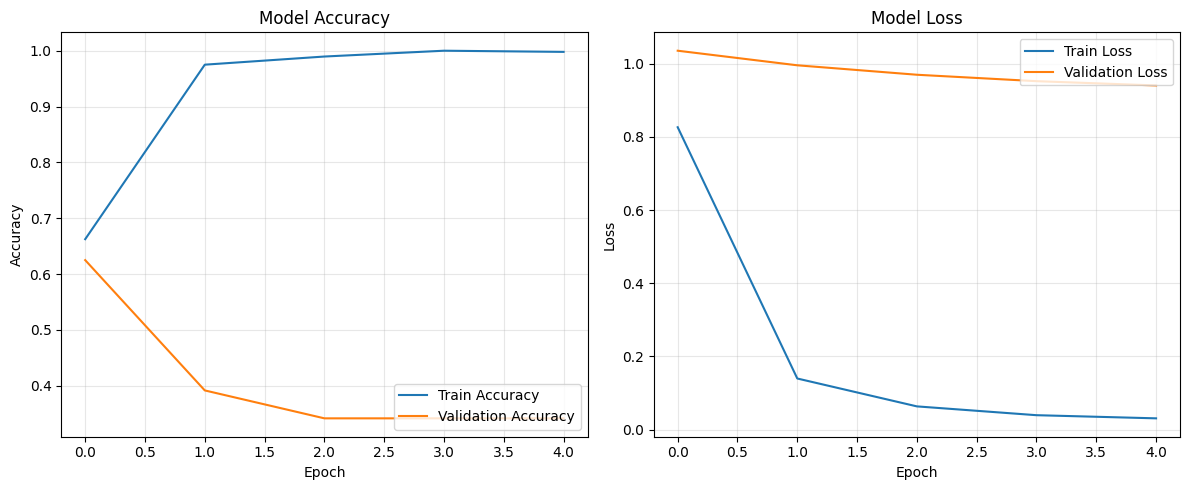

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


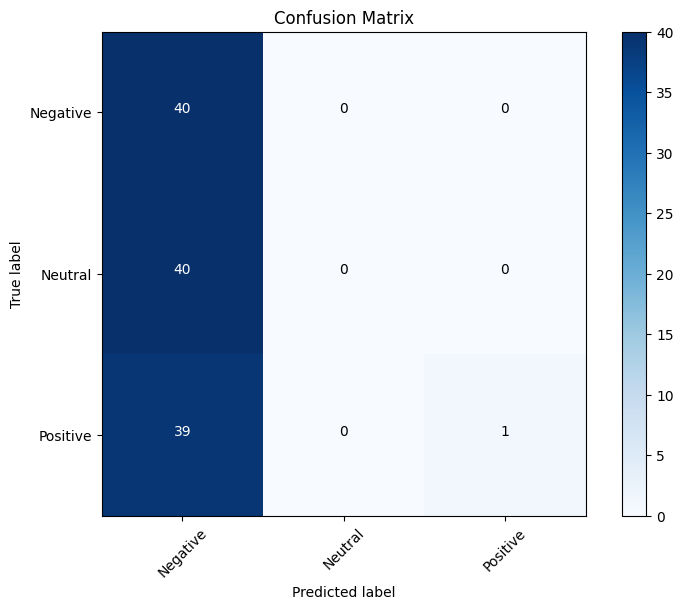


Classification Report:
              precision    recall  f1-score   support

    Negative       0.34      1.00      0.50        40
     Neutral       0.00      0.00      0.00        40
    Positive       1.00      0.03      0.05        40

    accuracy                           0.34       120
   macro avg       0.45      0.34      0.18       120
weighted avg       0.45      0.34      0.18       120


=== BERT for Feature Extraction ===
Building and training BERT feature extraction model...


ValueError: Exception encountered when calling layer 'keras_layer_8' (type KerasLayer).

A KerasTensor is symbolic: it's a placeholder for a shape an a dtype. It doesn't have any actual numerical value. You cannot convert it to a NumPy array.

Call arguments received by layer 'keras_layer_8' (type KerasLayer):
  • inputs=<KerasTensor shape=(None,), dtype=string, sparse=False, name=text_input>
  • training=None

In [ ]:
"""
# NLP Transfer Learning
# This implementation demonstrates transfer learning for NLP using:
# 1. Universal Sentence Encoder for feature extraction
# 2. BERT for both feature extraction and fine-tuning
# 3. Sentiment analysis with performance comparisons
"""

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow_hub as hub
import tensorflow_text  # Required for BERT preprocessing
import time

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

print("TensorFlow version:", tf.__version__)

class NLPTransferLearning:
    def __init__(self, max_seq_length=128):
        """
        Initialize the NLP Transfer Learning class

        Parameters:
        -----------
        max_seq_length : int
            Maximum sequence length for BERT tokenization
        """
        self.max_seq_length = max_seq_length

        # Initialize variables
        self.X_train = None
        self.X_test = None
        self.y_train = None
        self.y_test = None
        self.model = None
        self.history = None
        self.class_names = None
        self.n_classes = None

        # Load Universal Sentence Encoder and BERT preprocessor
        print("Loading pre-trained models...")
        try:
            # Load Universal Sentence Encoder
            print("Loading Universal Sentence Encoder...")
            self.use_model = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")
            print("Universal Sentence Encoder loaded successfully!")

            # Load BERT preprocessor and encoder as KerasLayers
            print("Loading BERT models...")
            self.bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
            self.bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/2")
            print("BERT models loaded successfully!")
        except Exception as e:
            print(f"Error loading pre-trained models: {e}")
            print("Some functionality might be limited.")

    def generate_sample_data(self, n_samples=1000, test_size=0.2):
        """
        Generate sample text data for sentiment analysis

        Parameters:
        -----------
        n_samples : int
            Number of samples to generate
        test_size : float
            Proportion of data to use for testing

        Returns:
        --------
        X_train, X_test, y_train, y_test : numpy arrays
            Training and test data
        """
        print("Generating sample sentiment analysis data...")

        # Set number of classes (positive/negative/neutral)
        self.n_classes = 3
        self.class_names = ['Negative', 'Neutral', 'Positive']

        # Templates for generating synthetic sentiment data
        positive_templates = [
            "I really enjoyed {item}, it was {positive_adj}.",
            "The {item} was {positive_adj} and {positive_adj}.",
            "I had a wonderful experience with {item}.",
            "The {item} exceeded my expectations in every way.",
            "I'm very satisfied with my {item} purchase.",
            "{item} is definitely worth the price.",
            "I would highly recommend {item} to anyone.",
            "This is the best {item} I've ever used.",
            "I love how {positive_adj} the {item} is.",
            "The {item} works perfectly and is very {positive_adj}."
        ]

        neutral_templates = [
            "The {item} was average, nothing special.",
            "I have mixed feelings about the {item}.",
            "The {item} was okay but not great.",
            "I neither liked nor disliked the {item}.",
            "The {item} met basic expectations.",
            "I'm undecided about whether to recommend the {item}.",
            "The {item} has both good and bad features.",
            "The {item} was somewhat {positive_adj} but also {negative_adj}.",
            "I don't have strong feelings about the {item}.",
            "The {item} was just alright."
        ]

        negative_templates = [
            "I really disliked the {item}, it was {negative_adj}.",
            "The {item} was {negative_adj} and {negative_adj}.",
            "I had a terrible experience with the {item}.",
            "The {item} fell short of my expectations.",
            "I'm very dissatisfied with my {item} purchase.",
            "The {item} is definitely not worth the price.",
            "I would not recommend the {item} to anyone.",
            "This is the worst {item} I've ever used.",
            "I hate how {negative_adj} the {item} is.",
            "The {item} doesn't work properly and is very {negative_adj}."
        ]

        items = [
            "product", "phone", "laptop", "service", "restaurant", "movie",
            "book", "hotel", "car", "experience", "meal", "show", "app",
            "game", "camera", "headphones", "software", "tablet", "TV", "speaker"
        ]

        positive_adjectives = [
            "excellent", "amazing", "fantastic", "great", "awesome",
            "wonderful", "superb", "outstanding", "impressive", "exceptional",
            "high-quality", "reliable", "brilliant", "delightful", "perfect"
        ]

        negative_adjectives = [
            "terrible", "awful", "horrible", "poor", "bad",
            "disappointing", "frustrating", "useless", "defective", "subpar",
            "low-quality", "unreliable", "mediocre", "annoying", "dreadful"
        ]

        # Generate synthetic data
        texts = []
        labels = []

        for i in range(n_samples):
            # Select sentiment class
            label = i % self.n_classes  # 0: negative, 1: neutral, 2: positive

            if label == 0:  # Negative
                template = np.random.choice(negative_templates)
                item = np.random.choice(items)
                adj1 = np.random.choice(negative_adjectives)
                adj2 = np.random.choice(negative_adjectives)
                text = template.format(item=item, negative_adj=adj1, positive_adj=adj2)
            elif label == 1:  # Neutral
                template = np.random.choice(neutral_templates)
                item = np.random.choice(items)
                pos_adj = np.random.choice(positive_adjectives)
                neg_adj = np.random.choice(negative_adjectives)
                text = template.format(item=item, positive_adj=pos_adj, negative_adj=neg_adj)
            else:  # Positive
                template = np.random.choice(positive_templates)
                item = np.random.choice(items)
                adj1 = np.random.choice(positive_adjectives)
                adj2 = np.random.choice(positive_adjectives)
                text = template.format(item=item, positive_adj=adj1, negative_adj=adj2)

            texts.append(text)
            labels.append(label)

        # Convert to numpy arrays
        texts = np.array(texts)
        labels = np.array(labels)

        # Split into training and test sets
        X_train, X_test, y_train, y_test = train_test_split(
            texts, labels, test_size=test_size, random_state=42, stratify=labels
        )

        # One-hot encode labels
        y_train = keras.utils.to_categorical(y_train, num_classes=self.n_classes)
        y_test = keras.utils.to_categorical(y_test, num_classes=self.n_classes)

        self.X_train = X_train
        self.X_test = X_test
        self.y_train = y_train
        self.y_test = y_test

        print(f"Sample data generated: {len(X_train)} training samples, {len(X_test)} test samples")
        return X_train, X_test, y_train, y_test

    def get_use_embeddings(self, texts):
        """
        Get Universal Sentence Encoder embeddings for texts

        Parameters:
        -----------
        texts : array-like
            Array of text strings

        Returns:
        --------
        embeddings : numpy array
            USE embeddings for the input texts
        """
        return self.use_model(texts).numpy()

    def train_use_model(self, dropout_rate=0.2, epochs=5, batch_size=32):
        """
        Train a model using Universal Sentence Encoder embeddings

        Parameters:
        -----------
        dropout_rate : float
            Dropout rate for regularization
        epochs : int
            Number of training epochs
        batch_size : int
            Batch size for training

        Returns:
        --------
        history : History object
            Training history
        """
        print("Building and training Universal Sentence Encoder model...")

        # Get embeddings for training data
        print("Getting USE embeddings for training data...")
        start_time = time.time()
        train_embeddings = self.get_use_embeddings(self.X_train)
        embedding_time = time.time() - start_time
        print(f"Embedding time: {embedding_time:.2f} seconds")
        print(f"Embedding dimension: {train_embeddings.shape[1]}")

        # Get embeddings for test data
        print("Getting USE embeddings for test data...")
        test_embeddings = self.get_use_embeddings(self.X_test)

        # Create model
        start_time = time.time()

        # Get embedding dimension
        embedding_dim = train_embeddings.shape[1]

        # Create model
        inputs = layers.Input(shape=(embedding_dim,), dtype=tf.float32)
        x = layers.Dense(128, activation='relu')(inputs)
        x = layers.BatchNormalization()(x)
        x = layers.Dropout(dropout_rate)(x)
        x = layers.Dense(64, activation='relu')(x)
        x = layers.BatchNormalization()(x)
        x = layers.Dropout(dropout_rate)(x)
        outputs = layers.Dense(self.n_classes, activation='softmax')(x)

        model = keras.Model(inputs=inputs, outputs=outputs)

        # Compile model
        model.compile(
            optimizer=keras.optimizers.Adam(learning_rate=0.001),
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )

        # Print model summary
        model.summary()

        # Add callbacks
        callbacks = [
            keras.callbacks.EarlyStopping(
                monitor='val_loss', patience=3, restore_best_weights=True
            )
        ]

        # Train the model
        print("Training Universal Sentence Encoder model...")
        history = model.fit(
            train_embeddings, self.y_train,
            epochs=epochs,
            batch_size=batch_size,
            validation_data=(test_embeddings, self.y_test),
            callbacks=callbacks,
            verbose=1
        )

        training_time = time.time() - start_time
        print(f"Training time: {training_time:.2f} seconds")

        # Evaluate the model
        test_loss, test_acc = model.evaluate(test_embeddings, self.y_test, verbose=1)
        print(f"Test accuracy: {test_acc:.4f}")

        # Store model and history
        self.model = model
        self.history = history
        self.model_type = 'use'

        # Store embeddings for later use
        self.train_embeddings = train_embeddings
        self.test_embeddings = test_embeddings

        return history, test_acc, training_time

    def train_bert_feature_extraction(self, dropout_rate=0.1, epochs=3, batch_size=16):
        """Train a model using BERT for feature extraction (frozen BERT layers)"""
        print("Building and training BERT feature extraction model...")

        start_time = time.time()

        # Text input
        text_input = layers.Input(shape=(), dtype=tf.string, name='text_input')

        # Build the model in a single flow
        encoder_inputs = self.bert_preprocess(text_input)
        bert_outputs = self.bert_encoder(encoder_inputs)
        pooled_output = bert_outputs["pooled_output"]

        # Add classification layers
        x = layers.Dropout(dropout_rate)(pooled_output)
        x = layers.Dense(128, activation='relu')(x)
        x = layers.BatchNormalization()(x)
        x = layers.Dropout(dropout_rate)(x)
        outputs = layers.Dense(self.n_classes, activation='softmax')(x)

        # Create model
        model = keras.Model(inputs=text_input, outputs=outputs)

        # Set BERT layer to non-trainable
        self.bert_encoder.trainable = False

        # Compile model
        model.compile(
            optimizer=keras.optimizers.Adam(learning_rate=2e-5),
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )

        # Print model summary
        model.summary()

        # Add callbacks
        callbacks = [
            keras.callbacks.EarlyStopping(
                monitor='val_loss', patience=2, restore_best_weights=True
            )
        ]

        # Train the model
        print("Training BERT feature extraction model...")
        history = model.fit(
            self.X_train, self.y_train,
            epochs=epochs,
            batch_size=batch_size,
            validation_data=(self.X_test, self.y_test),
            callbacks=callbacks,
            verbose=1
        )

        training_time = time.time() - start_time
        print(f"Training time: {training_time:.2f} seconds")

        # Evaluate the model
        test_loss, test_acc = model.evaluate(self.X_test, self.y_test, verbose=1)
        print(f"Test accuracy: {test_acc:.4f}")

        # Store model and history
        self.model = model
        self.history = history
        self.model_type = 'bert_feature_extraction'

        return history, test_acc, training_time

    def train_bert_fine_tuning(self, dropout_rate=0.1, epochs=3, batch_size=16):
        """Train a model for fine-tuning BERT"""
        print("Building and training BERT fine-tuning model...")

        start_time = time.time()

        # Text input
        text_input = layers.Input(shape=(), dtype=tf.string, name='text_input')

        # Build the model in a single flow
        encoder_inputs = self.bert_preprocess(text_input)
        bert_outputs = self.bert_encoder(encoder_inputs)
        pooled_output = bert_outputs["pooled_output"]

        # Add a simple classification layer for fine-tuning
        x = layers.Dropout(dropout_rate)(pooled_output)
        outputs = layers.Dense(self.n_classes, activation='softmax')(x)

        # Create model
        model = keras.Model(inputs=text_input, outputs=outputs)

        # Set BERT layer to trainable for fine-tuning
        self.bert_encoder.trainable = True

        # Compile with lower learning rate for fine-tuning
        model.compile(
            optimizer=keras.optimizers.Adam(learning_rate=3e-5),
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )

        # Print model summary
        model.summary()

        # Add callbacks
        callbacks = [
            keras.callbacks.EarlyStopping(
                monitor='val_loss', patience=2, restore_best_weights=True
            )
        ]

        # Train the model
        print("Training BERT fine-tuning model...")
        history = model.fit(
            self.X_train, self.y_train,
            epochs=epochs,
            batch_size=batch_size,
            validation_data=(self.X_test, self.y_test),
            callbacks=callbacks,
            verbose=1
        )

        training_time = time.time() - start_time
        print(f"Training time: {training_time:.2f} seconds")

        # Evaluate the model
        test_loss, test_acc = model.evaluate(self.X_test, self.y_test, verbose=1)
        print(f"Test accuracy: {test_acc:.4f}")

        # Store model and history
        self.model = model
        self.history = history
        self.model_type = 'bert_fine_tuning'

        return history, test_acc, training_time

    def visualize_training_history(self):
        """
        Visualize the training history
        """
        if self.history is None:
            print("Model has not been trained yet.")
            return

        # Plotting training history
        plt.figure(figsize=(12, 5))

        # Plot accuracy
        plt.subplot(1, 2, 1)
        plt.plot(self.history.history['accuracy'], label='Train Accuracy')
        plt.plot(self.history.history['val_accuracy'], label='Validation Accuracy')
        plt.title('Model Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend(loc='lower right')
        plt.grid(True, alpha=0.3)

        # Plot loss
        plt.subplot(1, 2, 2)
        plt.plot(self.history.history['loss'], label='Train Loss')
        plt.plot(self.history.history['val_loss'], label='Validation Loss')
        plt.title('Model Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend(loc='upper right')
        plt.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

    def visualize_confusion_matrix(self):
        """
        Visualize the confusion matrix
        """
        if not hasattr(self, 'model') or self.model is None:
            print("No model to evaluate. Train a model first.")
            return

        # For USE model, we need to get embeddings first
        if self.model_type == 'use':
            # Get predictions
            y_pred = self.model.predict(self.test_embeddings)
        else:  # BERT models
            # Get predictions
            y_pred = self.model.predict(self.X_test)

        # Get predicted and true classes
        y_pred_classes = np.argmax(y_pred, axis=1)
        y_true_classes = np.argmax(self.y_test, axis=1)

        # Compute confusion matrix
        cm = confusion_matrix(y_true_classes, y_pred_classes)

        # Plot confusion matrix
        plt.figure(figsize=(8, 6))
        plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
        plt.title('Confusion Matrix')
        plt.colorbar()

        # Add labels
        tick_marks = np.arange(len(self.class_names))
        plt.xticks(tick_marks, self.class_names, rotation=45)
        plt.yticks(tick_marks, self.class_names)

        # Add text annotations
        thresh = cm.max() / 2.
        for i in range(cm.shape[0]):
            for j in range(cm.shape[1]):
                plt.text(j, i, format(cm[i, j], 'd'),
                        horizontalalignment="center",
                        color="white" if cm[i, j] > thresh else "black")

        plt.tight_layout()
        plt.ylabel('True label')
        plt.xlabel('Predicted label')
        plt.show()

        # Print classification report
        print("\nClassification Report:")
        print(classification_report(y_true_classes, y_pred_classes,
                                   target_names=self.class_names))

    def predict_sentiment(self, texts):
        """
        Predict sentiment for new texts

        Parameters:
        -----------
        texts : list of str
            List of texts to predict sentiment for

        Returns:
        --------
        predictions : numpy array
            Predicted sentiment classes (0: negative, 1: neutral, 2: positive)
        confidence : numpy array
            Confidence scores for predictions
        """
        if not hasattr(self, 'model') or self.model is None:
            print("No model to predict with. Train a model first.")
            return None, None

        if not isinstance(texts, list):
            texts = [texts]

        # For USE model, we need to get embeddings first
        if self.model_type == 'use':
            # Get embeddings
            embeddings = self.get_use_embeddings(texts)
            # Get predictions
            predictions = self.model.predict(embeddings)
        else:  # BERT models
            # Get predictions directly
            predictions = self.model.predict(np.array(texts))

        # Get predicted classes and confidence
        predicted_classes = np.argmax(predictions, axis=1)
        confidence = np.max(predictions, axis=1)

        # Print results
        print("\nPrediction Results:")
        for i, (text, pred_class, conf) in enumerate(zip(texts, predicted_classes, confidence)):
            class_name = self.class_names[pred_class] if self.class_names else f"Class {pred_class}"
            print(f"Text {i+1}: \"{text}\"")
            print(f"Predicted sentiment: {class_name} (confidence: {conf:.4f})")
            print()

        return predicted_classes, confidence


# Function to run NLP transfer learning demo with all models
def run_nlp_transfer_learning_demo():
    """
    Demonstrate NLP transfer learning with all three approaches:
    1. Universal Sentence Encoder for feature extraction
    2. BERT for feature extraction
    3. BERT for fine-tuning

    Compares performance, training time, and accuracy across all models.
    """
    print("Starting NLP Transfer Learning Demo")

    # Initialize the NLP Transfer Learning class
    nlp_tl = NLPTransferLearning()

    # Generate sample data
    X_train, X_test, y_train, y_test = nlp_tl.generate_sample_data(n_samples=600, test_size=0.2)

    # Dictionary to store results
    results = {
        'model': [],
        'test_accuracy': [],
        'training_time': []
    }

    # 1. Universal Sentence Encoder Model
    print("\n=== Universal Sentence Encoder for Feature Extraction ===")
    use_history, use_acc, use_time = nlp_tl.train_use_model(epochs=5, batch_size=32)
    nlp_tl.visualize_training_history()
    nlp_tl.visualize_confusion_matrix()

    # Store results
    results['model'].append('Universal Sentence Encoder')
    results['test_accuracy'].append(use_acc)
    results['training_time'].append(use_time)

    # 2. BERT Feature Extraction Model
    print("\n=== BERT for Feature Extraction ===")
    bert_fe_history, bert_fe_acc, bert_fe_time = nlp_tl.train_bert_feature_extraction(epochs=3, batch_size=16)
    nlp_tl.visualize_training_history()
    nlp_tl.visualize_confusion_matrix()

    # Store results
    results['model'].append('BERT Feature Extraction')
    results['test_accuracy'].append(bert_fe_acc)
    results['training_time'].append(bert_fe_time)

    # 3. BERT Fine-Tuning Model
    print("\n=== BERT for Fine-Tuning ===")
    bert_ft_history, bert_ft_acc, bert_ft_time = nlp_tl.train_bert_fine_tuning(epochs=3, batch_size=16)
    nlp_tl.visualize_training_history()
    nlp_tl.visualize_confusion_matrix()

    # Store results
    results['model'].append('BERT Fine-Tuning')
    results['test_accuracy'].append(bert_ft_acc)
    results['training_time'].append(bert_ft_time)

    # Convert results to DataFrame for easier visualization
    results_df = pd.DataFrame(results)
    print("\n=== Model Comparison ===")
    print(results_df)

    # Plot accuracy comparison
    plt.figure(figsize=(14, 6))

    # Plot accuracy vs. time
    plt.subplot(1, 2, 1)
    plt.bar(results['model'], results['test_accuracy'], color=['#3498db', '#2ecc71', '#e74c3c'])
    plt.title('Model Accuracy Comparison')
    plt.ylabel('Test Accuracy')
    plt.ylim([0, 1.0])
    plt.xticks(rotation=45, ha='right')

    # Add accuracy values on top of bars
    for i, acc in enumerate(results['test_accuracy']):
        plt.text(i, acc + 0.02, f'{acc:.4f}', ha='center', va='bottom')

    # Plot training time
    plt.subplot(1, 2, 2)
    plt.bar(results['model'], results['training_time'], color=['#3498db', '#2ecc71', '#e74c3c'])
    plt.title('Training Time Comparison')
    plt.ylabel('Time (seconds)')
    plt.xticks(rotation=45, ha='right')

    # Add time values on top of bars
    for i, t in enumerate(results['training_time']):
        plt.text(i, t + 1, f'{t:.1f}s', ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

    # Test on some examples
    test_texts = [
        "I absolutely loved this product, it exceeded all my expectations!",
        "The service was okay, nothing special.",
        "This was a terrible experience, I would never recommend it to anyone."
    ]

    # Predictions with the last trained model (BERT Fine-Tuning)
    print("\n=== Sample Predictions ===")
    nlp_tl.predict_sentiment(test_texts)

    return nlp_tl, results_df

# Run the demonstration when the script is executed
if __name__ == "__main__":
    nlp_tl, results_df = run_nlp_transfer_learning_demo()